# Post-processing

In this tutorial we demonstrate the functionality and posterior operations supported by the [PostProcessing](postprocessing.rst) module.

In [1]:
%matplotlib inline

from __future__ import division

import sys
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import math

from collections import OrderedDict

from matplotlib import pyplot as plt
plt.rc('font', size=20.0)

In [2]:
import xpsi

from xpsi import PostProcessing

# choose a seed for the notebook if you want caching to be useful
# and the notebook exactly reproducible
PostProcessing.set_random_seed(0)

from xpsi.global_imports import gravradius

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|             Version: 0.5.0.dev4             |
|---------------------------------------------|
|  https://thomasedwardriley.github.io/xpsi/  |
\=============================================/

Imported GetDist version: 0.3.1
Imported nestcheck version: 0.2.0


Below we import a reproduced pair of models from [Riley et al. (2019)](https://arxiv.org/abs/1912.05702), together with the posterior sample files which may be acquired from a [Zenodo](http://doi.org/10.5281/zenodo.3707821) repository.

## Model loading & metadata

Let's instantiate the likelihood object for each model and import it (a basic check of the likelihood callable is also performed in each module):

In [3]:
%%capture
from STU_modules import main as STU
from ST_PST_modules import main as ST_PST

We need the names of the free parameters defined for the ST-U model so we can name the parameters in the sample files to match:

In [4]:
STU.likelihood # NB: not ordered in same manner as sample files due to API changes

Free parameters
---------------
mass: Gravitational mass [solar masses].
radius: Coordinate equatorial radius [km].
distance: Earth distance [kpc].
cos_inclination: Cosine of Earth inclination to rotation axis.
p__phase_shift: The phase of the hot region, a periodic parameter [cycles].
p__super_colatitude: The colatitude of the centre of the superseding region [radians].
p__super_radius: The angular radius of the (circular) superseding region [radians].
p__super_temperature: log10(superseding region effective temperature [K]).
s__phase_shift: The phase of the hot region, a periodic parameter [cycles].
s__super_colatitude: The colatitude of the centre of the superseding region [radians].
s__super_radius: The angular radius of the (circular) superseding region [radians].
s__super_temperature: log10(superseding region effective temperature [K]).
alpha: alpha.
beta: beta.
gamma: gamma.
column_density: Units of 10^20 cm^-2.

We want to invoke the post-processing module. First we need to load run sets, including metadata:

In [5]:
# names of free parameters ordered as in sample files
# NB: the parameter named cos_inclination in the sample files is
#     actually the inclination, but the name is declared here to
#     link it to the inclination parameter in the current API, which
#     is the cos(inclination). We do this because the inclinations
#     on disk will be transformed to cos(inclination) by the
#     CustomPrior.transform() instance method with the argument
#     old_API=True.
STU.names = ['distance', 'mass', 'radius', 'cos_inclination',
             'p__super_colatitude', 'p__super_radius', 'p__super_temperature',
             's__super_colatitude', 's__super_radius', 's__super_temperature',
             'column_density',
             'alpha', 'beta', 'gamma',
             'p__phase_shift', 's__phase_shift']

# names of derived variables of interest
STU.names += ['compactness', 's__transformed_phase']

# the hard bounds imposed above for each parameter
# in some cases, depending on how the prior density
# is constructed, automated population of the
# dictionary below might not yield the required bounds,
# whereas manual population of the dictionary allows
# the user to take full control
STU.bounds = {'distance': (0.235, 0.415),
              'mass': (1.0, 3.0),
              'radius': (3.0 * gravradius(1.0), 16.0),
              'cos_inclination': (0.0, math.cos(0.001)),
              'p__super_colatitude': (0.001, math.pi - 0.001),
              'p__super_radius': (0.001, math.pi/2.0 - 0.001),
              'p__super_temperature': (5.1, 6.8),
              's__super_colatitude': (0.001, math.pi - 0.001),
              's__super_radius': (0.001, math.pi/2.0 - 0.001),
              's__super_temperature': (5.1, 6.8),
              'column_density': (0.0, 5.0),
              'alpha': (0.5,1.5),
              'beta': (0.0,1.0),
              'gamma': (0.5,1.5),
              'p__phase_shift': (-0.5,0.5),
              's__phase_shift': (-0.5,0.5),
              'compactness': (gravradius(1.0)/16.0, 1.0/3.0),
              's__transformed_phase': (-1.0,0.0)}

# TeX compatible labels
STU.labels = {'distance': r"D\;\mathrm{[kpc]}",
              'mass': r"M\;\mathrm{[M}_{\odot}\mathrm{]}",
              'radius': r"R_{\mathrm{eq}}\;\mathrm{[km]}",
              'cos_inclination': r"\cos(i)",
              'p__super_colatitude': r"\Theta_{p}\;\mathrm{[rad]}",
              'p__super_radius': r"\zeta_{p}\;\mathrm{[rad]}",
              'p__super_temperature': r"\mathrm{log10}(T_{p}\;[\mathrm{K}])",
              's__super_colatitude': r"\Theta_{s}\;\mathrm{[rad]}",
              's__super_radius': r"\zeta_{s}\;\mathrm{[rad]}",
              's__super_temperature': r"\mathrm{log10}(T_{s}\;[\mathrm{K}])",
              'column_density': r"N_{\mathrm{H}}\;\mathrm{[10^{20}\;cm^{-2}]}",
              'alpha': r"\alpha",
              'beta': r"\beta",
              'gamma': r"\gamma",
              'p__phase_shift': r"\phi_{p}\;\mathrm{[cycles]}",
              's__phase_shift': r"\phi_{s}\;\mathrm{[cycles]}",
              'compactness': r"M/R_{\mathrm{eq}}",
              's__transformed_phase': r"\phi_{s}\;\mathrm{[cycles]}",}

And for the ST+PST model:

In [6]:
ST_PST.likelihood # NB: not ordered in same manner as sample files due to API changes

Free parameters
---------------
mass: Gravitational mass [solar masses].
radius: Coordinate equatorial radius [km].
distance: Earth distance [kpc].
cos_inclination: Cosine of Earth inclination to rotation axis.
p__phase_shift: The phase of the hot region, a periodic parameter [cycles].
p__super_colatitude: The colatitude of the centre of the superseding region [radians].
p__super_radius: The angular radius of the (circular) superseding region [radians].
p__super_temperature: log10(superseding region effective temperature [K]).
s__phase_shift: The phase of the hot region, a periodic parameter [cycles].
s__super_colatitude: The colatitude of the centre of the superseding region [radians].
s__super_radius: The angular radius of the (circular) superseding region [radians].
s__super_temperature: log10(superseding region effective temperature [K]).
s__omit_colatitude: The colatitude of the centre of the omission region [radians].
s__omit_radius: The angular radius of the (circular) omission 

In [7]:
# names of free parameters ordered as in sample files
ST_PST.names = ['distance', 'mass', 'radius', 'cos_inclination',
                 'p__super_colatitude', 'p__super_radius', 'p__super_temperature',
                 's__super_colatitude', 's__super_radius', 's__omit_colatitude',
                 's__omit_radius', 's__omit_azimuth', 's__super_temperature', 
                 'column_density',
                 'alpha', 'beta', 'gamma',
                 'p__phase_shift', 's__phase_shift']

# names of derived variables of interest
ST_PST.names += ['compactness',
                 's__annulus_width',
                 's__transformed_phase',
                 's__f',
                 's__xi',
                 's__super_offset_fraction',
                 's__super_offset_azi']

ST_PST.bounds = {'distance': (0.235, 0.415),
                  'mass': (1.0, 3.0),
                  'radius': (3.0 * gravradius(1.0), 16.0),
                  'cos_inclination': (0.0, math.cos(0.001)),
                  'p__super_colatitude': (0.001, math.pi - 0.001),
                  'p__super_radius': (0.001, math.pi/2.0 - 0.001),
                  'p__super_temperature': (5.1, 6.8),
                  's__super_colatitude': (0.001, math.pi - 0.001),
                  's__super_radius': (0.001, math.pi/2.0 - 0.001),
                  's__super_temperature': (5.1, 6.8),
                  's__omit_colatitude': (0.001, math.pi - 0.001),
                  's__omit_radius': (0.0, math.pi/2.0 - 0.001),
                  's__omit_azimuth': (-math.pi, math.pi),
                  'column_density': (0.0, 5.0),
                  'alpha': (0.5,1.5),
                  'beta': (0.0,1.0),
                  'gamma': (0.5,1.5),
                  'p__phase_shift': (-0.5,0.5),
                  's__phase_shift': (-0.5,0.5),
                  'compactness': (gravradius(1.0)/16.0, 1.0/3.0),
                  's__annulus_width': (-math.pi/2.0 + 0.001, math.pi/2.0 - 0.001),
                  's__transformed_phase': (-1.0, 0.0),
                  's__f': (0.0, 2.0),
                  's__xi': (0.001, math.pi/2.0 - 0.001),
                  's__super_offset_fraction': (0.0, 1.0),
                  's__super_offset_azi': (0.0, 2.0)}

ST_PST.labels = {'distance': r"D\;\mathrm{[kpc]}",
                  'mass': r"M\;\mathrm{[M}_{\odot}\mathrm{]}",
                  'radius': r"R_{\mathrm{eq}}\;\mathrm{[km]}",
                  'cos_inclination': r"\cos(i)",
                  'p__super_colatitude': r"\Theta_{p}\;\mathrm{[rad]}",
                  'p__super_radius': r"\zeta_{p}\;\mathrm{[rad]}",
                  'p__super_temperature': r"\mathrm{log10}(T_{p}\;[\mathrm{K}])",
                  's__super_colatitude': r"\Theta_{s}\;\mathrm{[rad]}",
                  's__super_radius': r"\zeta_{s}\;\mathrm{[rad]}",
                  's__super_temperature': r"\mathrm{log10}(T_{s}\;[\mathrm{K}])",
                  's__omit_colatitude': r"\Theta_{s}\;\mathrm{[rad]}",
                  's__omit_radius': r"\psi_{s}\;\mathrm{[rad]}",
                  's__omit_azimuth': r".", # won't bother plotting so no need for symbol
                  'column_density': r"N_{\mathrm{H}}\;\mathrm{[10^{20}\;cm^{-2}]}",
                  'alpha': r"\alpha",
                  'beta': r"\beta",
                  'gamma': r"\gamma",
                  'p__phase_shift': r"\phi_{p}\;\mathrm{[cycles]}",
                  's__phase_shift': r"\phi_{s}\;\mathrm{[cycles]}",
                  'compactness': r"M/R_{\mathrm{eq}}",
                  's__annulus_width': r"\psi^{+}\;\mathrm{[rad]}",
                  's__transformed_phase': r"\phi_{s}\;\mathrm{[cycles]}",
                  's__f': r"f_{s}",
                  's__xi': r"\xi_{s}\;\mathrm{[rad]}",
                  's__super_offset_fraction': r"\kappa_{s}",
                  's__super_offset_azi': r"\varphi_{s}\;\mathrm{[\pi\,radians]}"}

We need to specify how the Gaussian KDE should be executed. We'll use the same settings for each model. See GetDist source code and documentation for more information.

In [8]:
getdist_kde_settings = {'ignore_rows': 0,
                         'min_weight_ratio': 1.0e-10,
                         'contours': [0.683, 0.954, 0.997],
                         'credible_interval_threshold': 0.001,
                         'range_ND_contour': 0,
                         'range_confidence': 0.001,
                         'fine_bins': 1024,
                         'smooth_scale_1D': 0.4,
                         'num_bins': 100,
                         'boundary_correction_order': 1,
                         'mult_bias_correction_order': 1,
                         'smooth_scale_2D': 0.4,
                         'max_corr_2D': 0.99,
                         'fine_bins_2D': 512,
                         'num_bins_2D': 40}

Now we load the nested sampling runs for each model into a container, and create attributes in the module namespaces. These containers are designed to hold nested samplign runs on the same posterior distribution.  The required metadata is captured by ``**kwargs`` and transmitted to base classes.

In [9]:
STU.runs = xpsi.Runs.load_runs(ID='ST-U',
                               run_IDs=['run 1', 'run 2', 'mode separation'],
                               roots=['run1/run1_nlive1000_eff0.3_noCONST_noMM_noIS_tol-3',
                                      'run2/run2_nlive1000_eff0.3_noCONST_noMM_noIS_tol-3',
                                      'run3/run1_nlive1000_eff0.3_noCONST_MM_tol-1'],
                               base_dirs=['../../STU_v2/'] * 3,
                               use_nestcheck=[True,True,False],
                               kde_settings=getdist_kde_settings,
                               likelihood=STU.likelihood,
                               names=STU.names,
                               bounds=STU.bounds,
                               labels=STU.labels,
                               implementation='multinest',
                               overwrite_transformed=True)

In [10]:
ST_PST.runs = xpsi.Runs.load_runs('ST+PST',
                                  ['ST+PST',],
                                  ['run1/run1_nlive1000_eff0.3_noCONST_noMM_noIS_tol-1',],
                                  base_dirs=['../../ST_PST/'],
                                  use_nestcheck=[True],
                                  kde_settings=getdist_kde_settings,
                                  likelihood=ST_PST.likelihood,
                                  names=ST_PST.names,
                                  bounds=ST_PST.bounds,
                                  labels=ST_PST.labels,
                                  implementation='multinest',
                                  overwrite_transformed=True)

## Marginal posterior plotting & estimators

The post-processor base class can ingest multiple posteriors, and the `xpsi.PostProcessing.CornerPlotter` subclass for corner (lower-triangle) plotting may be utilized as follows:

In [11]:
pp = xpsi.PostProcessing.CornerPlotter([STU.runs, ST_PST.runs])

Now we plot the marginal posterior density distributions for the ST-U model, along with other estimators such as the per-parameter KL-divergence and credible intervals. We also combine runs that can be combined. All of this is executed via a single function call that can take many arguments and produce plots with a substantial information density.

Executing posterior density estimation...
Curating set of runs for posterior plotting...
Run set curated.
Constructing lower-triangle posterior density plot via Gaussian KDE:
plotting:  ['radius', 'compactness']
plotting:  ['radius', 'mass']
plotting:  ['compactness', 'mass']
Applying bespoke parameter viewing intervals...
Viewing intervals applied.
Adding 1D marginal prior density functions...
Plotting prior for posterior ST-U...
Drawing samples from the joint prior...
Samples drawn.
Estimating 1D marginal KL-divergences in bits...
radius KL-divergence = 1.4440...
compactness KL-divergence = 2.5560...
mass KL-divergence = 2.0763...
Estimated 1D marginal KL-divergences.
Added 1D marginal prior density functions.
Veneering spines and axis ticks...
Veneered.
Adding 1D marginal credible intervals...
Plotting credible regions for posterior ST-U...
Added 1D marginal credible intervals.
Constructed lower-triangle posterior density plot.
Posterior density estimation complete.


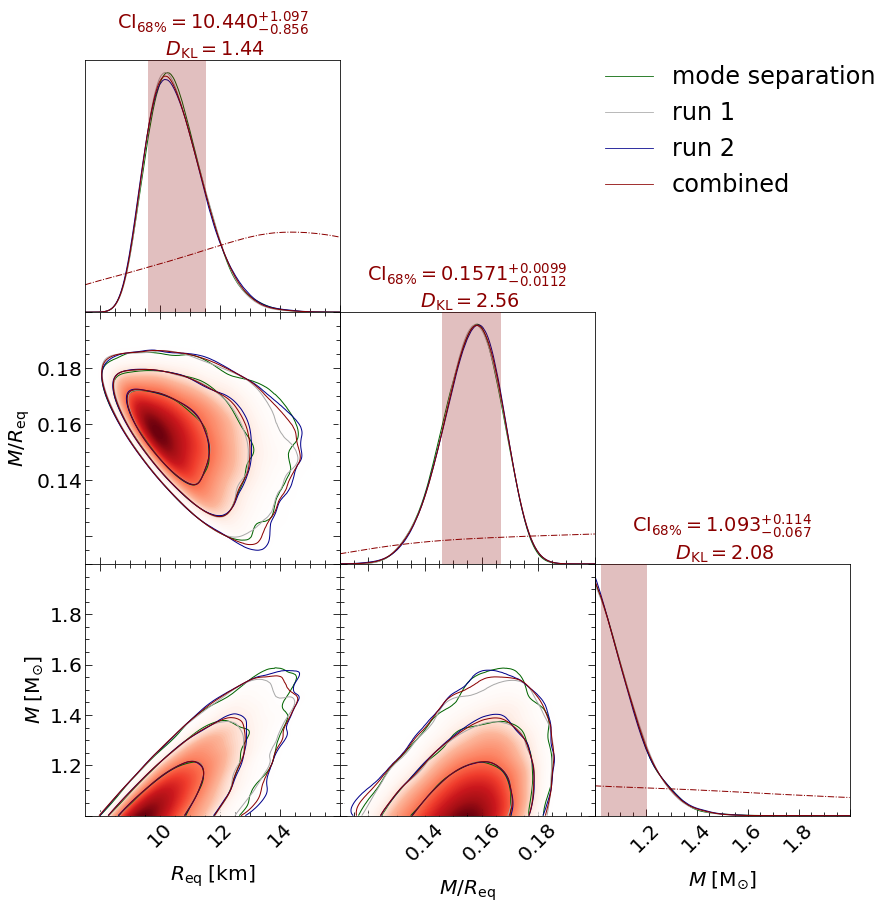

In [12]:
_ = pp.plot(
     params=['radius','compactness','mass'],
     IDs=OrderedDict([('ST-U', ['mode separation', 'run 2', 'run 1',]),]),
     prior_density=True,
     KL_divergence=True,
     ndraws=5e4,
     combine=True, combine_all=True, only_combined=False, overwrite_combined=True,
     param_plot_lims={'radius': (7.5,16.0), 'compactness': (0.11,0.20), 'mass': (1.0,2.0)},
     bootstrap_estimators=False,
     bootstrap_density=False,
     n_simulate=200,
     crosshairs=False,
     write=False,
     ext='.png',
     maxdots=3000,
     root_filename='STU_spacetime',
     credible_interval_1d=True,
     annotate_credible_interval=True,
     compute_all_intervals=False,
     sixtyeight=True,
     x_label_rotation=45.0,
     num_plot_contours=3,
     subplot_size=4.0,
     legend_corner_coords=(0.675,0.8),
     legend_frameon=False,
     scale_attrs=OrderedDict([('legend_fontsize', 2.0),
                              ('lab_fontsize', 1.35),
                              ('axes_fontsize', 'lab_fontsize'),
                             ]
                            ),
     colormap='Reds',
     shaded=True,
     shade_root_index=-1,
     rasterized_shade=True,
     no_ylabel=True,
     no_ytick=True,
     lw=1.0,
     lw_1d=1.0,
     filled=False,
     normalize=True,
     veneer=True,
     tqdm_kwargs={'disable': False},
     lengthen=2.0,
     embolden=1.0,
     nx=500,
     scale_ymax=1.1)

Now we overlay the two models. In the case of a posterior with multiple runs that were elligble for combination, they are automatically combined and only the combined run is displayed. The order of the posteriors is controlled by the ordered of identifiers passed (but note that there are some ulterior rules that override this order).

Executing posterior density estimation...
Curating set of runs for posterior plotting...
Run set curated.
Constructing lower-triangle posterior density plot via Gaussian KDE:
plotting:  ['radius', 'compactness']
plotting:  ['radius', 'mass']
plotting:  ['compactness', 'mass']
Applying bespoke parameter viewing intervals...
Viewing intervals applied.
Adding 1D marginal prior density functions...
Plotting prior for posterior ST+PST...
Drawing samples from the joint prior...
Samples drawn.
Estimating 1D marginal KL-divergences in bits...
radius KL-divergence = 0.7815/-0.0216/+0.0245...
compactness KL-divergence = 2.7638/-0.0317/+0.0312...
mass KL-divergence = 1.2564/-0.0243/+0.0195...
Estimated 1D marginal KL-divergences.
Added 1D marginal prior density functions.
Adding 1D marginal prior density functions...
Plotting prior for posterior ST-U...
Drawing samples from the joint prior...
Samples drawn.
Added 1D marginal prior density functions.
Veneering spines and axis ticks...
Veneered.
Ad

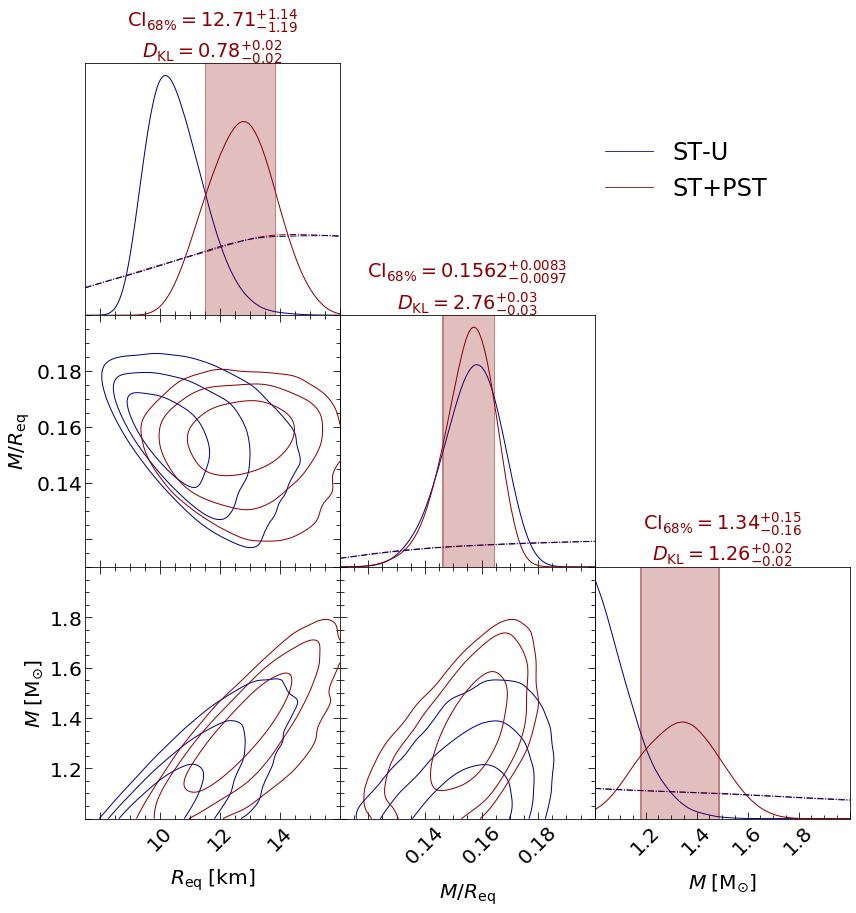

In [13]:
_ = pp.plot(
     params=['radius','compactness','mass'],
     IDs=OrderedDict([('ST+PST', ['ST+PST',]),
                       ('ST-U', ['mode separation', 'run 2', 'run 1',]),]),
     prior_density=True,
     KL_divergence=True,
     ndraws=5e4,
     combine=True, combine_all=True, only_combined=False, overwrite_combined=True,
     param_plot_lims={'radius': (7.5,16.0), 'compactness': (0.11,0.20), 'mass': (1.0,2.0)},
     bootstrap_estimators=True,
     bootstrap_density=False,
     crosshairs=False,
     write=False,
     ext='.png',
     maxdots=3000,
     root_filename='STU_STPST_spacetime',
     credible_interval_1d=True,
     annotate_credible_interval=True,
     compute_all_intervals=False,
     sixtyeight=True,
     x_label_rotation=45.0,
     num_plot_contours=3,
     subplot_size=4.0,
     legend_corner_coords=(0.675,0.8),
     legend_frameon=False,
     scale_attrs=OrderedDict([('legend_fontsize', 2.0),
                              ('lab_fontsize', 1.35),
                              ('axes_fontsize', 'lab_fontsize'),
                             ]
                            ),
     colormap='Reds',
     shaded=False,
     shade_root_index=-1,
     rasterized_shade=True,
     no_ylabel=True,
     no_ytick=True,
     lw=1.0,
     lw_1d=1.0,
     filled=False,
     normalize=True,
     veneer=True,
     tqdm_kwargs={'disable': False},
     lengthen=2.0,
     embolden=1.0,
     nx=500,
     scale_ymax=1.1,
     n_simulate=200
)

Let's add some parameters associated with the primary hot region:

Executing posterior density estimation...
Curating set of runs for posterior plotting...
Run set curated.
Constructing lower-triangle posterior density plot via Gaussian KDE:
plotting:  ['radius', 'mass']
plotting:  ['radius', 'p__super_colatitude']
plotting:  ['radius', 'p__phase_shift']
plotting:  ['radius', 'p__super_radius']
plotting:  ['radius', 'p__super_temperature']
plotting:  ['radius', 's__super_temperature']
plotting:  ['mass', 'p__super_colatitude']
plotting:  ['mass', 'p__phase_shift']
plotting:  ['mass', 'p__super_radius']
plotting:  ['mass', 'p__super_temperature']
plotting:  ['mass', 's__super_temperature']
plotting:  ['p__super_colatitude', 'p__phase_shift']
plotting:  ['p__super_colatitude', 'p__super_radius']
plotting:  ['p__super_colatitude', 'p__super_temperature']
plotting:  ['p__super_colatitude', 's__super_temperature']
plotting:  ['p__phase_shift', 'p__super_radius']
plotting:  ['p__phase_shift', 'p__super_temperature']
plotting:  ['p__phase_shift', 's__super_t

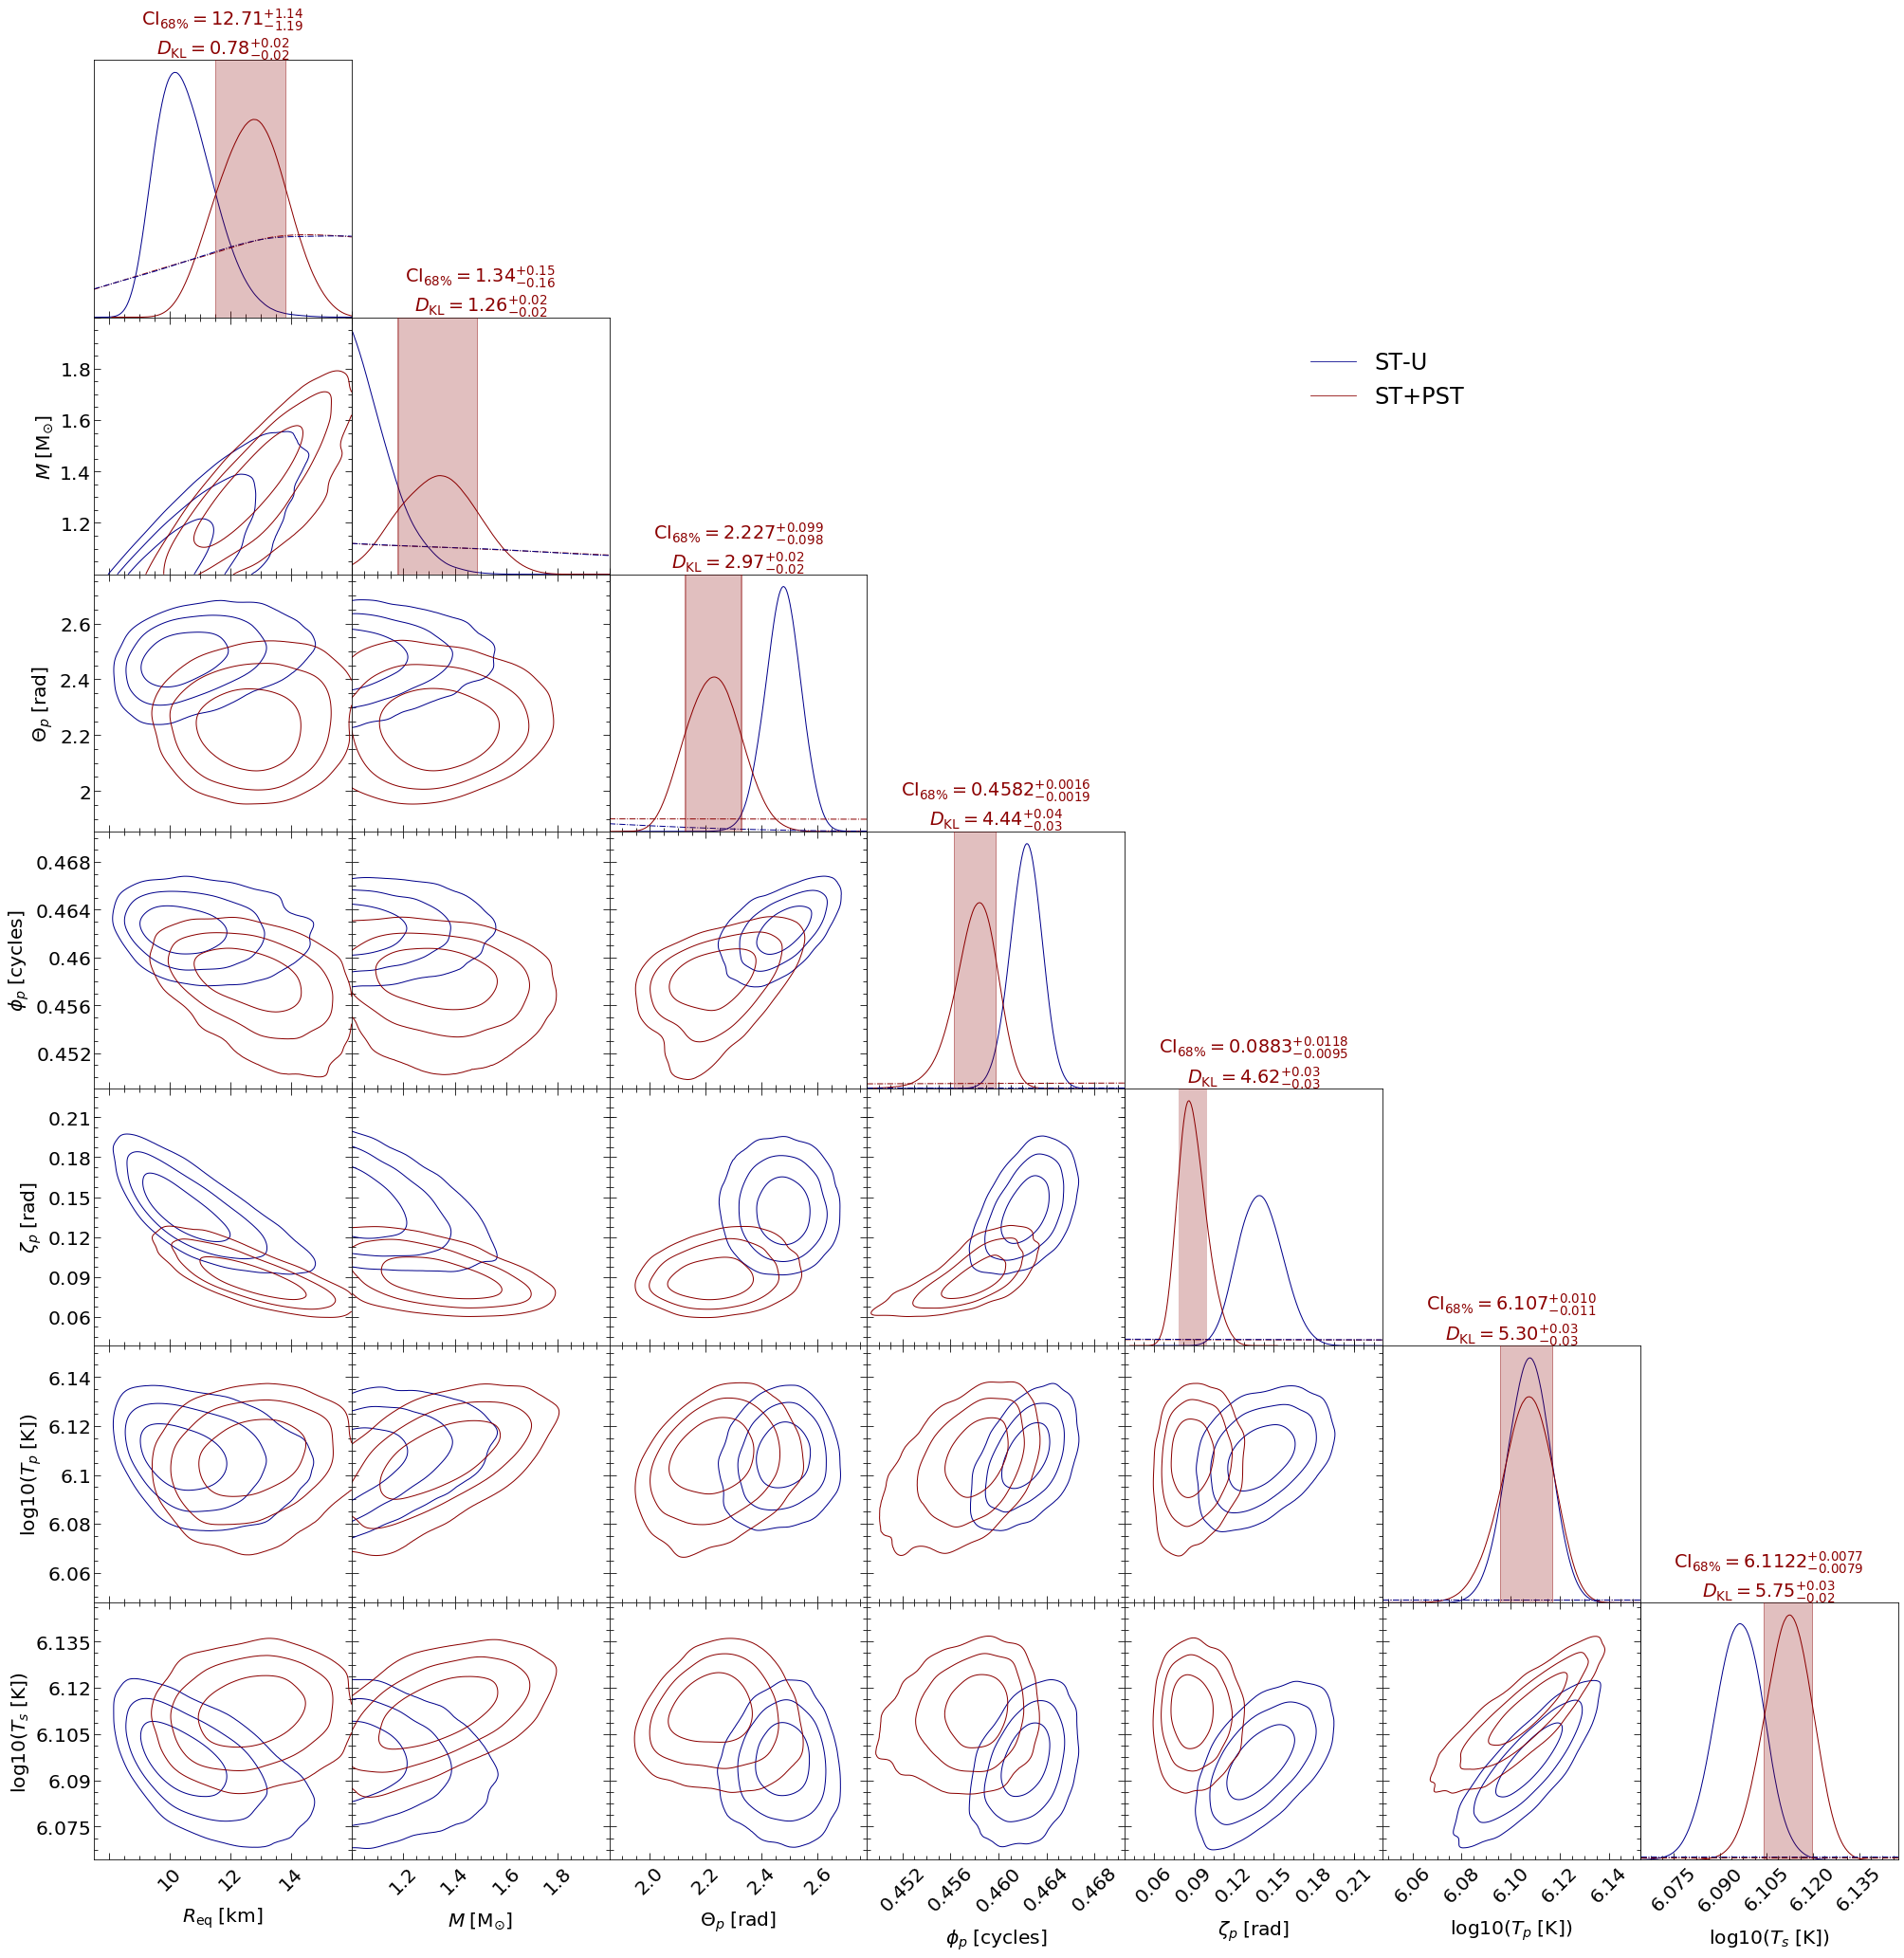

In [14]:
_ = pp.plot(
     params=['radius','mass',
             'p__super_colatitude',
             'p__phase_shift',
             'p__super_radius',
             'p__super_temperature',
             's__super_temperature',],
     IDs=OrderedDict([('ST+PST', ['ST+PST',]),
                       ('ST-U', ['mode separation', 'run 2', 'run 1',]),]),
     prior_density=True,
     KL_divergence=True,
     ndraws=5e4,
     combine=True, combine_all=True, only_combined=False, overwrite_combined=True,
     param_plot_lims={'radius': (7.5,16.0), 'mass': (1.0,2.0)},
     bootstrap_estimators=True,
     bootstrap_density=False,
     crosshairs=False,
     write=False,
     ext='.png',
     maxdots=3000,
     root_filename='STU_STPST_source',
     credible_interval_1d=True,
     annotate_credible_interval=True,
     compute_all_intervals=False,
     sixtyeight=True,
     x_label_rotation=45.0,
     num_plot_contours=3,
     subplot_size=4.0,
     legend_corner_coords=(0.675,0.8),
     legend_frameon=False,
     scale_attrs=OrderedDict([('legend_fontsize', 2.0),
                              ('lab_fontsize', 1.35),
                              ('axes_fontsize', 'lab_fontsize'),
                             ]
                            ),
     colormap='Reds',
     shaded=False,
     shade_root_index=-1,
     rasterized_shade=True,
     no_ylabel=True,
     no_ytick=True,
     lw=1.0,
     lw_1d=1.0,
     filled=False,
     normalize=True,
     veneer=True,
     tqdm_kwargs={'disable': False},
     lengthen=2.0,
     embolden=1.0,
     nx=500,
     scale_ymax=1.1,
     n_simulate=200
)

The legend font size was much too small. Next time we will scale it up:

Executing posterior density estimation...
Curating set of runs for posterior plotting...
Run set curated.
Constructing lower-triangle posterior density plot via Gaussian KDE:
plotting:  ['distance', 'cos_inclination']
plotting:  ['distance', 'column_density']
plotting:  ['distance', 'alpha']
plotting:  ['distance', 'beta']
plotting:  ['distance', 'gamma']
plotting:  ['cos_inclination', 'column_density']
plotting:  ['cos_inclination', 'alpha']
plotting:  ['cos_inclination', 'beta']
plotting:  ['cos_inclination', 'gamma']
plotting:  ['column_density', 'alpha']
plotting:  ['column_density', 'beta']
plotting:  ['column_density', 'gamma']
plotting:  ['alpha', 'beta']
plotting:  ['alpha', 'gamma']
plotting:  ['beta', 'gamma']
Adding 1D marginal prior density functions...
Plotting prior for posterior ST+PST...
Drawing samples from the joint prior...
Samples drawn.
Estimating 1D marginal KL-divergences in bits...
distance KL-divergence = 0.0703...
cos_inclination KL-divergence = 1.5856...
colu

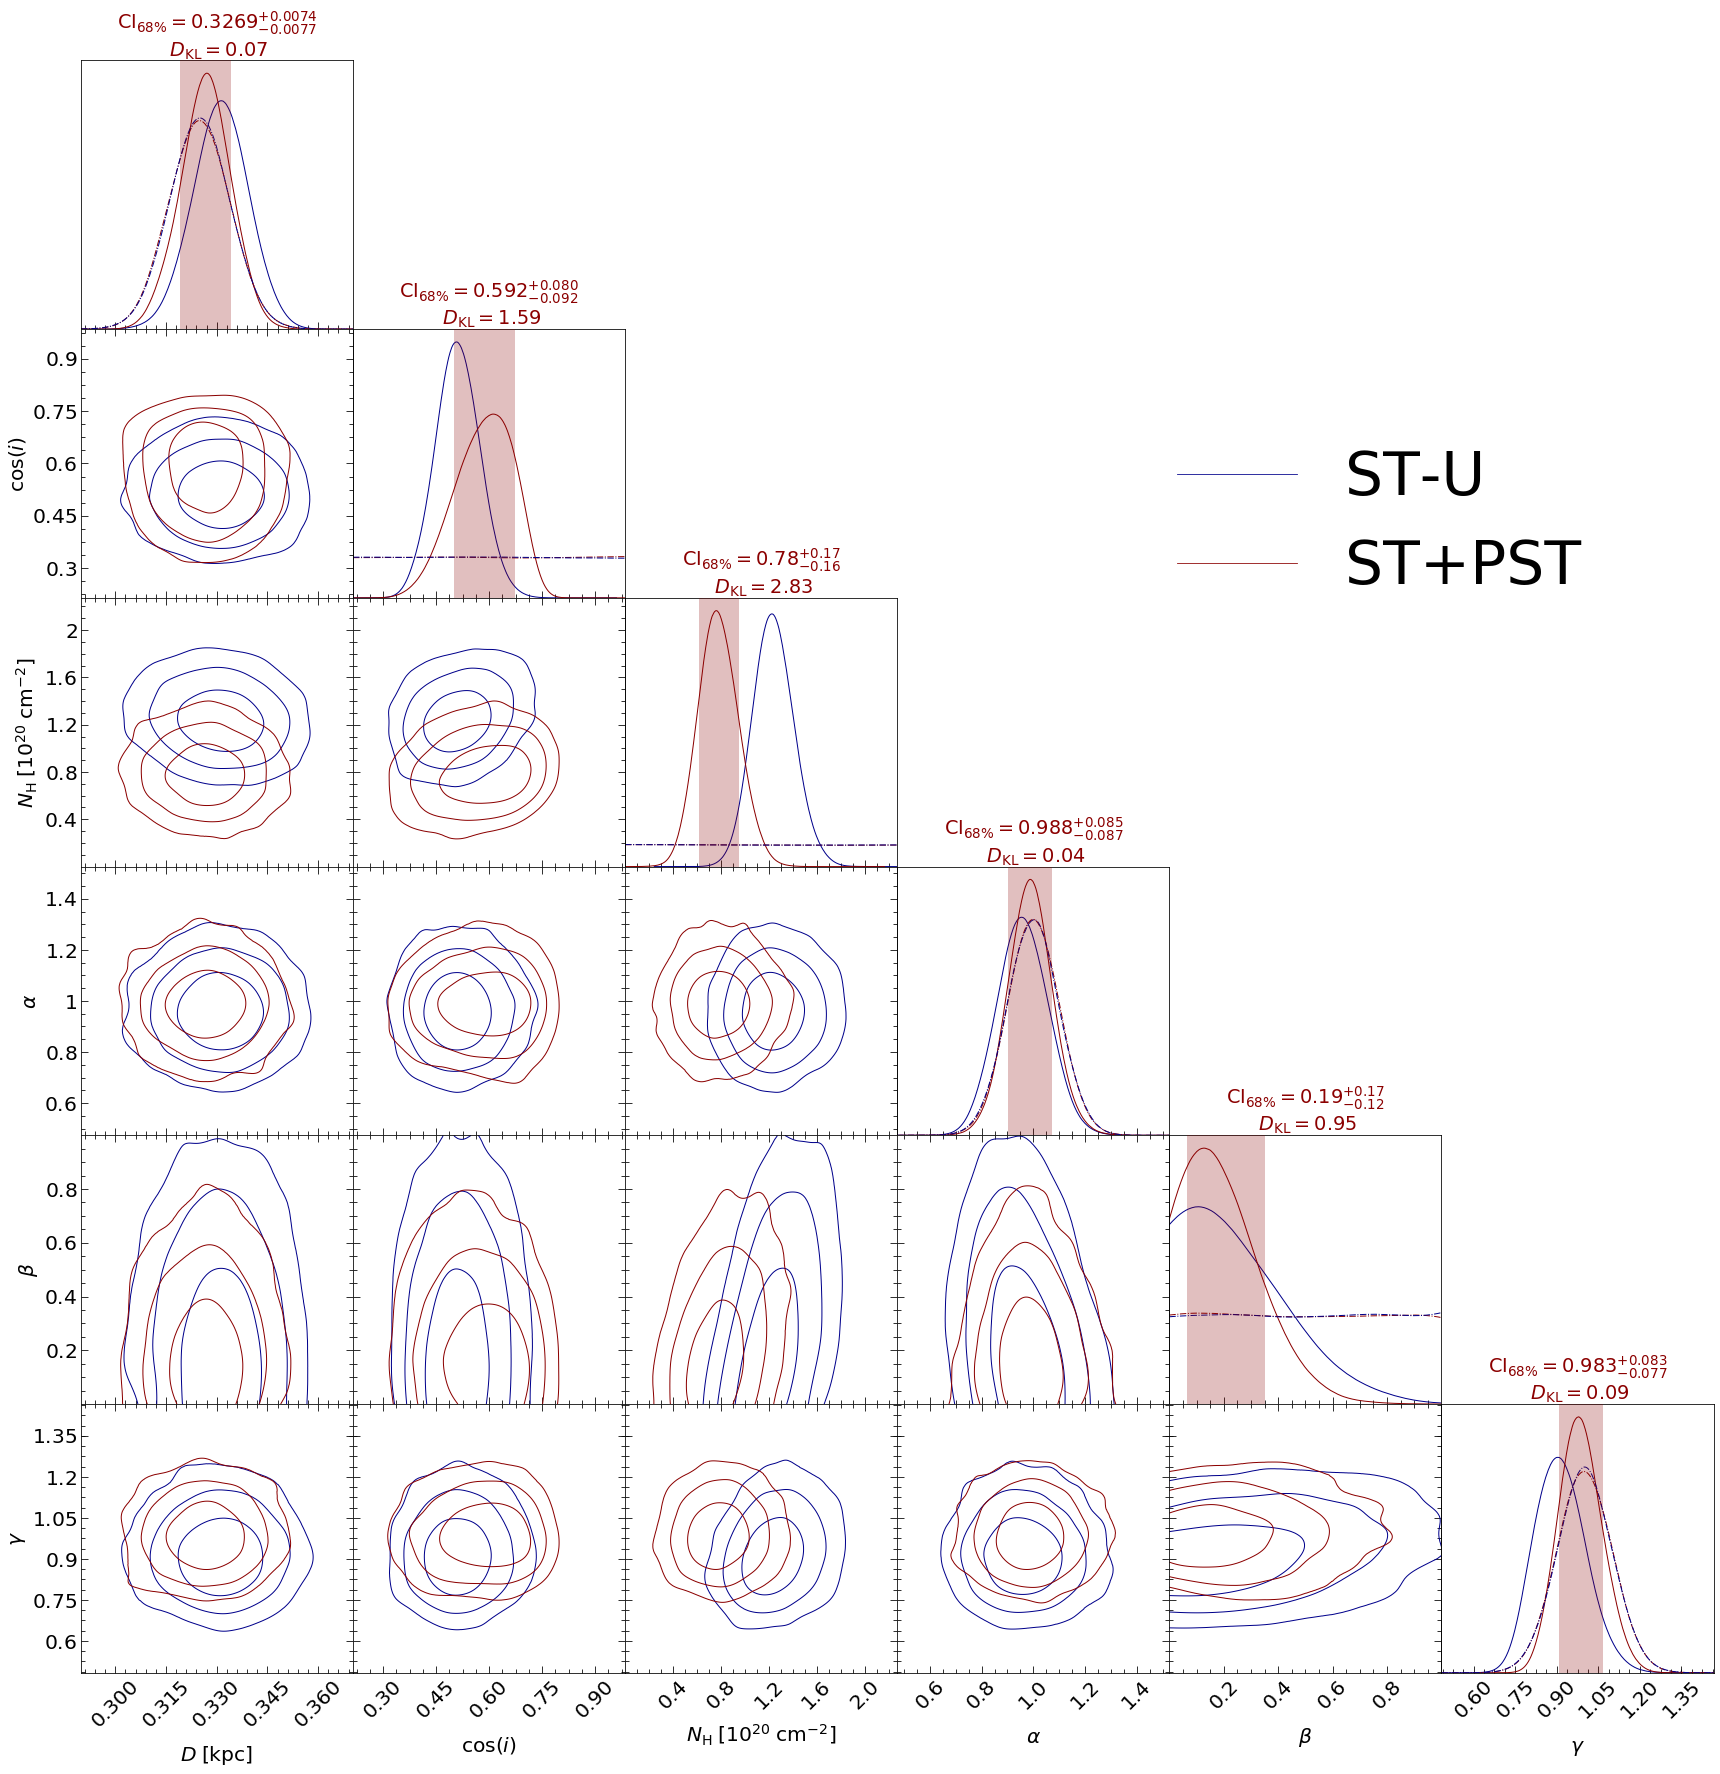

In [15]:
# NB: to plot the inclination below instead, we'd have to
#     transform to inclination as a derived parameter instead
#     of cos(inclination) -- see the CustomPrior class
_ = pp.plot(
     params=['distance','cos_inclination',
             'column_density',
             'alpha','beta','gamma',],
     IDs=OrderedDict([('ST+PST', ['ST+PST',]),
                       ('ST-U', ['mode separation', 'run 2', 'run 1',]),]),
     prior_density=True,
     KL_divergence=True,
     ndraws=5e4,
     combine=True, combine_all=True, only_combined=False, overwrite_combined=True,
     param_plot_lims={},
     bootstrap_estimators=False,
     bootstrap_density=False,
     crosshairs=False,
     write=False,
     ext='.png',
     maxdots=3000,
     root_filename='STU_STPST_observation',
     credible_interval_1d=True,
     annotate_credible_interval=True,
     compute_all_intervals=False,
     sixtyeight=True,
     x_label_rotation=45.0,
     num_plot_contours=3,
     subplot_size=4.0,
     legend_corner_coords=(0.65,0.65),
     legend_frameon=False,
     scale_attrs=OrderedDict([('legend_fontsize', 5.0), # means 5x the automated size
                              ('lab_fontsize', 1.35),
                              ('axes_fontsize', 'lab_fontsize'),
                             ]
                            ),
     colormap='Reds',
     shaded=False,
     shade_root_index=-1,
     rasterized_shade=True,
     no_ylabel=True,
     no_ytick=True,
     lw=1.0,
     lw_1d=1.0,
     filled=False,
     normalize=True,
     veneer=True,
     tqdm_kwargs={'disable': False},
     lengthen=2.0,
     embolden=1.0,
     nx=500,
     scale_ymax=1.1,
     n_simulate=200
)

Let's isolate the parameters of the secondary hot region in the ST+PST model because the geometric configurations they generate on the surface are different to the ST-U model:

Executing posterior density estimation...
Curating set of runs for posterior plotting...
Run set curated.
Constructing lower-triangle posterior density plot via Gaussian KDE:
plotting:  ['s__super_colatitude', 's__super_radius']
plotting:  ['s__super_colatitude', 's__annulus_width']
plotting:  ['s__super_colatitude', 's__super_offset_fraction']
plotting:  ['s__super_colatitude', 's__super_offset_azi']
plotting:  ['s__super_colatitude', 's__super_temperature']
plotting:  ['s__super_radius', 's__annulus_width']
plotting:  ['s__super_radius', 's__super_offset_fraction']
plotting:  ['s__super_radius', 's__super_offset_azi']
plotting:  ['s__super_radius', 's__super_temperature']
plotting:  ['s__annulus_width', 's__super_offset_fraction']
plotting:  ['s__annulus_width', 's__super_offset_azi']
plotting:  ['s__annulus_width', 's__super_temperature']
plotting:  ['s__super_offset_fraction', 's__super_offset_azi']
plotting:  ['s__super_offset_fraction', 's__super_temperature']
plotting:  ['s__sup

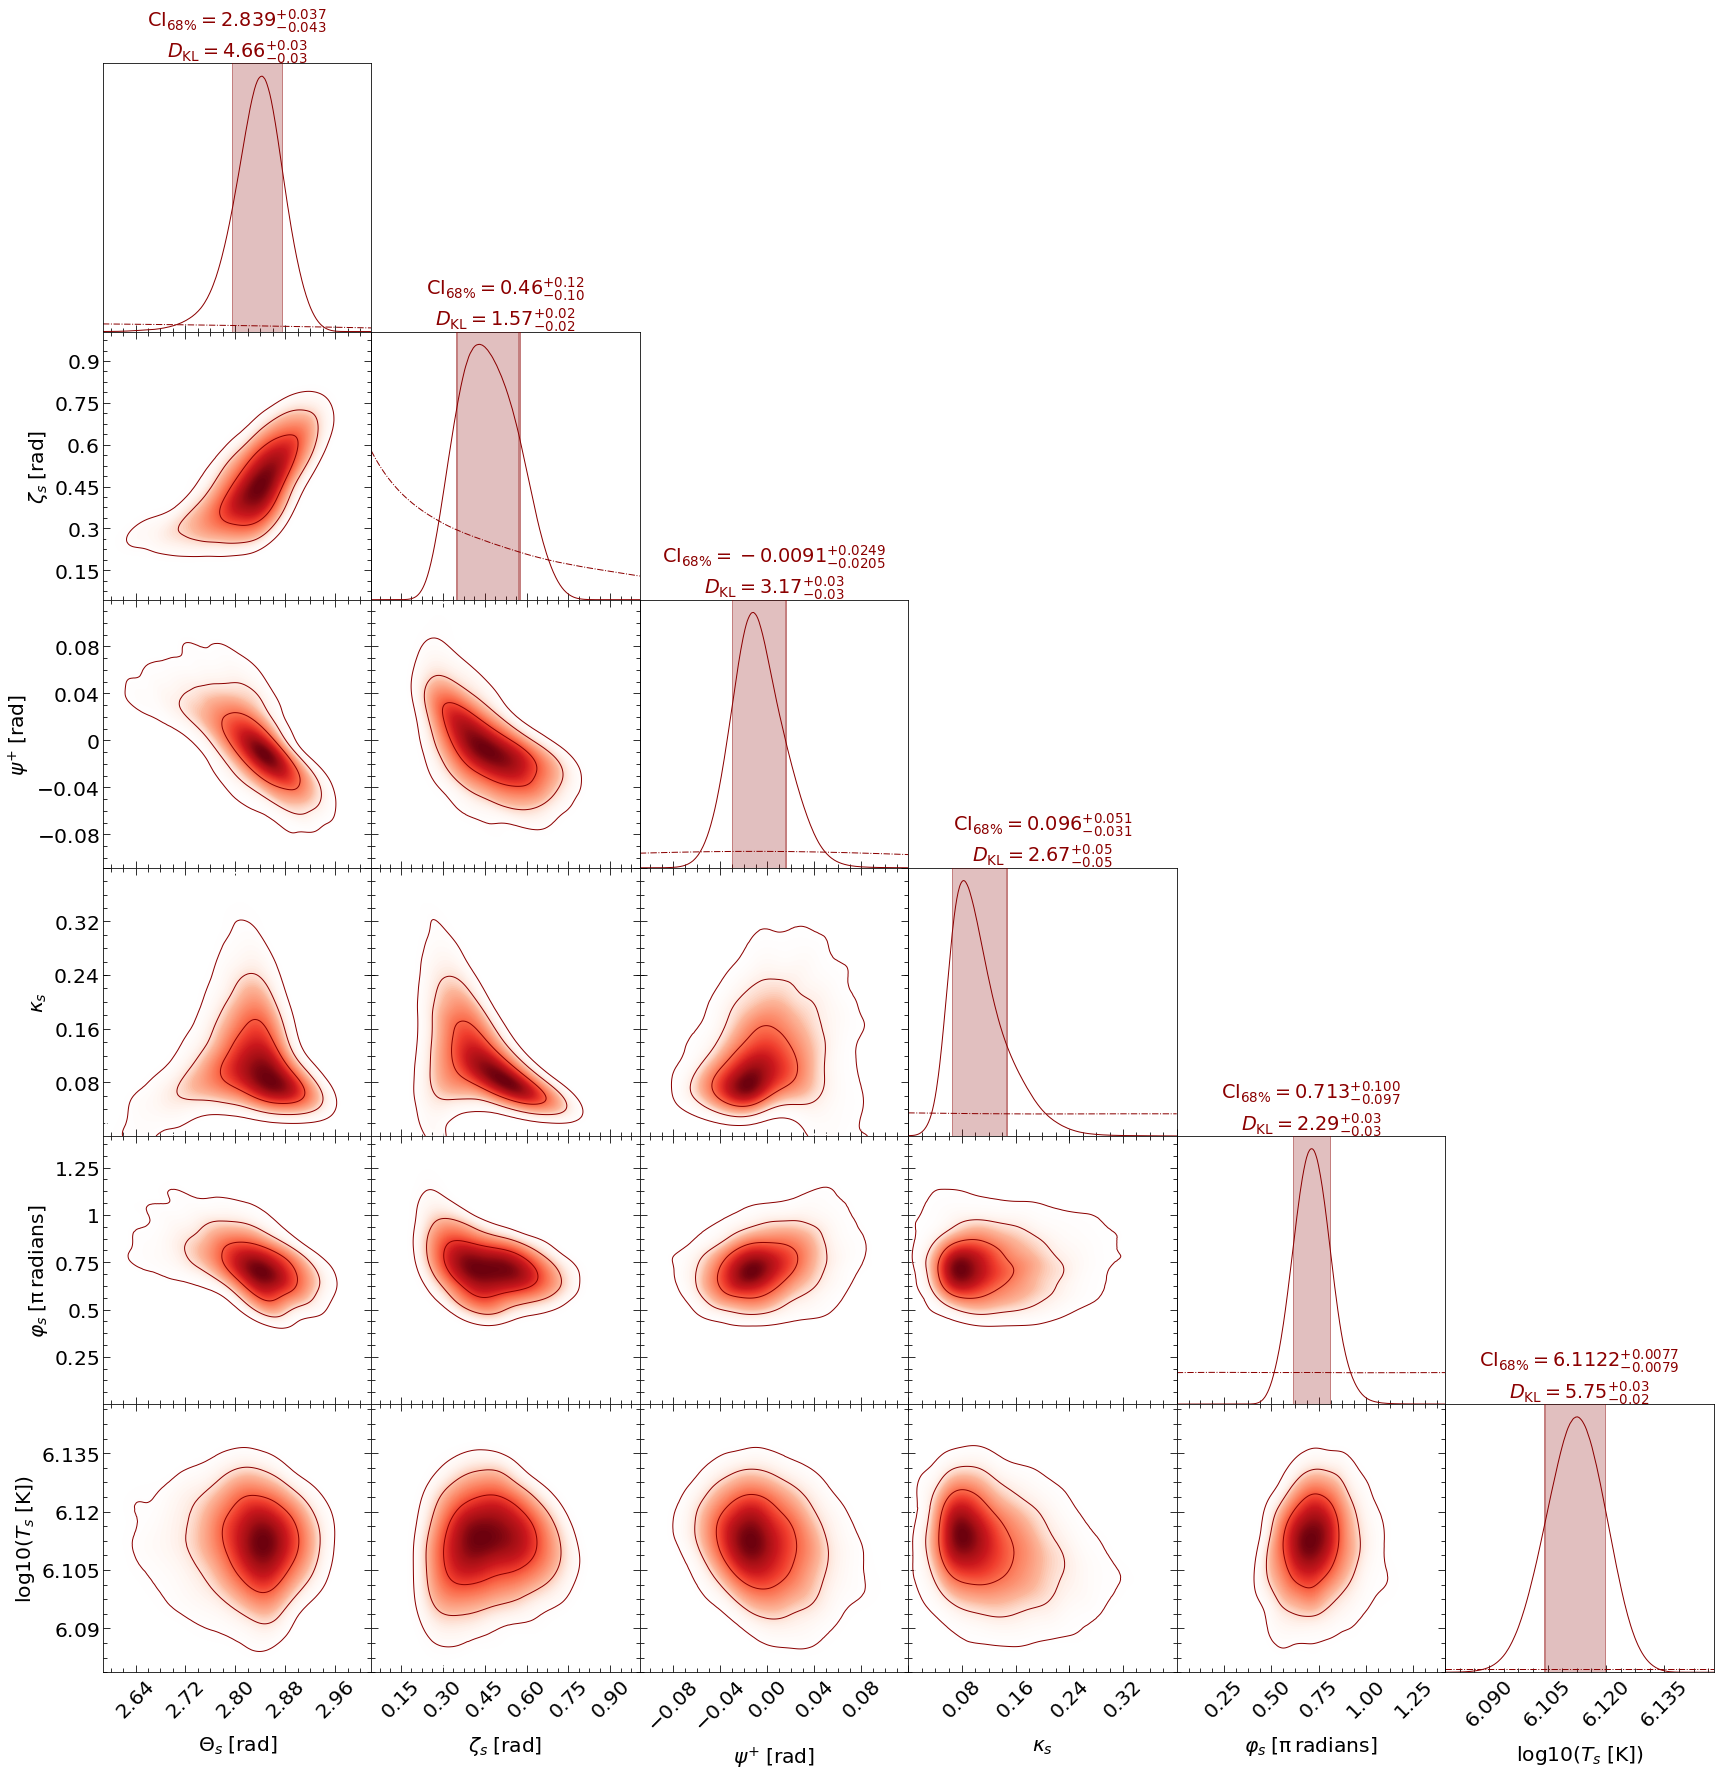

In [16]:
_ = pp.plot(
     params=['s__super_colatitude',
             's__super_radius',
             's__annulus_width',
             's__super_offset_fraction',
             's__super_offset_azi',
             's__super_temperature',],
     IDs=OrderedDict([('ST+PST', ['ST+PST',]),]),
     prior_density=True,
     KL_divergence=True,
     ndraws=5e4,
     combine=False, combine_all=False, only_combined=False,
     param_plot_lims={'s__super_offset_fraction':(0.0, 0.4)},
     bootstrap_estimators=True,
     bootstrap_density=False,
     crosshairs=False,
     write=False,
     ext='.png',
     maxdots=3000,
     root_filename='STPST_secondary_hot_region',
     credible_interval_1d=True,
     annotate_credible_interval=True,
     compute_all_intervals=False,
     sixtyeight=True,
     x_label_rotation=45.0,
     num_plot_contours=3,
     subplot_size=4.0,
     legend_corner_coords=(0.65,0.65),
     legend_frameon=False,
     scale_attrs=OrderedDict([('legend_fontsize', 5.0),
                              ('lab_fontsize', 1.35),
                              ('axes_fontsize', 'lab_fontsize'),
                             ]
                            ),
     colormap='Reds',
     shaded=True,
     shade_root_index=-1,
     rasterized_shade=True,
     no_ylabel=True,
     no_ytick=True,
     lw=1.0,
     lw_1d=1.0,
     filled=False,
     normalize=True,
     veneer=True,
     tqdm_kwargs={'disable': False},
     lengthen=2.0,
     embolden=1.0,
     nx=500,
     scale_ymax=1.1,
     n_simulate=200
)

Let's now estimate the error due to noise on the parameter density functions:

Executing posterior density estimation...
Curating set of runs for posterior plotting...
Run set curated.
Constructing lower-triangle posterior density plot via Gaussian KDE:
plotting:  ['radius', 'distance']
plotting:  ['radius', 'cos_inclination']
plotting:  ['radius', 'compactness']
plotting:  ['radius', 'mass']
plotting:  ['distance', 'cos_inclination']
plotting:  ['distance', 'compactness']
plotting:  ['distance', 'mass']
plotting:  ['cos_inclination', 'compactness']
plotting:  ['cos_inclination', 'mass']
plotting:  ['compactness', 'mass']
Applying bespoke parameter viewing intervals...
Viewing intervals applied.
Adding 1D marginal prior density functions...
Plotting prior for posterior ST-U...
Drawing samples from the joint prior...
Samples drawn.
Estimating 1D marginal KL-divergences in bits...
radius KL-divergence = 1.4660/-0.0366/+0.0363...
distance KL-divergence = 0.3448/-0.0299/+0.0241...
cos_inclination KL-divergence = 1.9357/-0.0306/+0.0343...
compactness KL-divergence = 2


Added density error information.
Simulated nested sampling realisations and plotted posterior density error estimates.
Posterior density estimation complete.


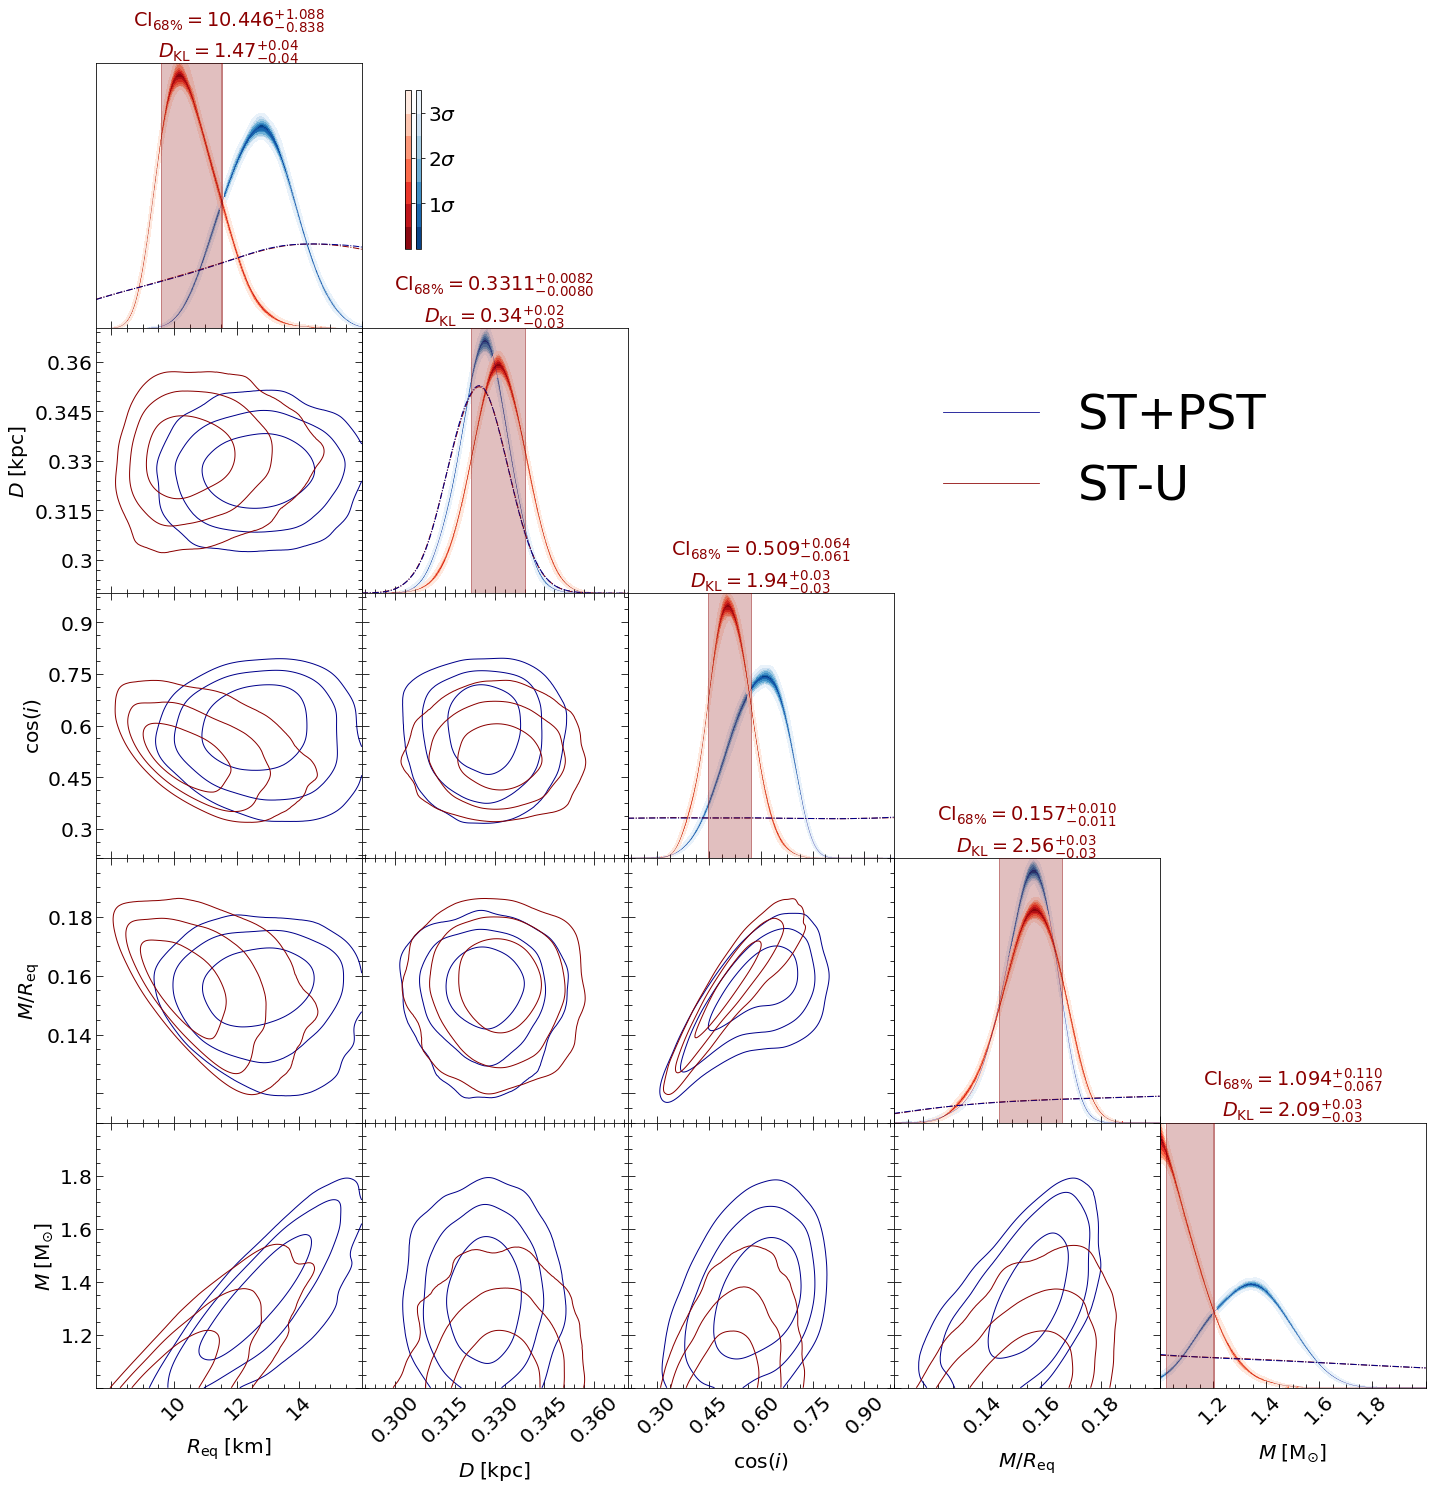

In [16]:
_ = pp.plot(
     params=['radius','distance','cos_inclination','compactness','mass'],
     IDs=OrderedDict([('ST-U', ['run 1',]),
                      ('ST+PST', ['ST+PST',]),
                     ]),
     prior_density=True,
     KL_divergence=True,
     ndraws=5e4,
     combine=True, combine_all=False, only_combined=False,
     param_plot_lims={'radius': (7.5,16.0), 'compactness': (0.11,0.20), 'mass': (1.0,2.0)},
     bootstrap_estimators=True,
     bootstrap_density=True,
     crosshairs=False,
     write=False,
     ext='.png',
     maxdots=3000,
     root_filename='STU_STPST_density_noise',
     credible_interval_1d=True,
     annotate_credible_interval=True,
     compute_all_intervals=False,
     sixtyeight=True,
     x_label_rotation=45.0,
     num_plot_contours=3,
     subplot_size=4.0,
     legend_corner_coords=(0.625,0.65),
     legend_frameon=False,
     scale_attrs=OrderedDict([('legend_fontsize', 4.0),
                              ('lab_fontsize', 1.35),
                              ('axes_fontsize', 'lab_fontsize'),
                             ]
                            ),
     colormap='Reds',
     shaded=False,
     shade_root_index=-1,
     rasterized_shade=True,
     no_ylabel=True,
     no_ytick=True,
     lw=1.0,
     lw_1d=0.25,
     filled=False,
     normalize=True,
     veneer=True,
     tqdm_kwargs={'disable': False},
     lengthen=2.0,
     embolden=1.0,
     nx=500,
     scale_ymax=1.1,
     n_simulate=200
)

We can simulate the error on the log-evidence for each model:

In [17]:
pp.evidence_error(IDs=OrderedDict([('ST+PST', ['ST+PST',]),
                                   ('ST-U', ['run 1',]),]))

Curating set of runs for posterior plotting...
Run set curated.


{'ST+PST.ST+PST': [-36367.19516498342, -36366.65975840585, -36366.03664145086],
 'ST-U.run 1': [-36378.113585862426, -36377.557340195526, -36376.99624703233]}

We can estimate the global KL-divergence and simulate the error for each model:

In [18]:
pp.KL_divergence(bootstrap=True) # the run subset was already selected by executing the cell above

{'ST+PST.ST+PST': [68.10142802456878, 68.93373033859666, 69.87495962878252],
 'ST-U.run 1': [62.85009300482493, 63.63732652113097, 64.46479567041214]}

## Conditional posterior signal plotting

Again, the post-processor base class can ingest multiple posteriors, and the `xpsi.PostProcessing.SignalPlotter` subclass for posterior signal plotting may be utilized as follows:

In [11]:
pp = xpsi.SignalPlotter([STU.runs, ST_PST.runs])

### Residual plots

Suppose we want a residual plot for each model. The class we need is [ResidualPlot](postprocessing.rst#xpsi.PostProcessing.ResidualPlot):

If we want to customize a modifiable few class attributes, before instantiation for safety, we can do it with:

In [20]:
xpsi.ResidualPlot.declare_settings?

Note that some have no effect because this is a base classmethod.

In [21]:
xpsi.ResidualPlot.declare_settings(extension='.png')

Declaring plot class settings...
Settings declared.


Instantiating a residual plotter for posterior checking...
Residual plotter instantiated.
Instantiating a residual plotter for posterior checking...
Residual plotter instantiated.
Plotting signals for posterior checking...
Curating set of runs for posterior plotting...
Run set curated.
Handling posterior ST-U...
Checking whether an existing cache can be read:
Cache state determined.
ResidualPlot object iterating over samples...
ResidualPlot object finished iterating.
ResidualPlot object finalizing...
ResidualPlot object finalized.
Writing plot to disk...
ResidualPlot instance plot will be written to path ./ST-U.run_1__signalplot_residuals.png...
Written.
Handled posterior ST-U.
Handling posterior ST+PST...
Checking whether an existing cache can be read:
Cache state determined.
ResidualPlot object iterating over samples...
ResidualPlot object finished iterating.
ResidualPlot object finalizing...
ResidualPlot object finalized.
Writing plot to disk...
ResidualPlot instance plot will be wr

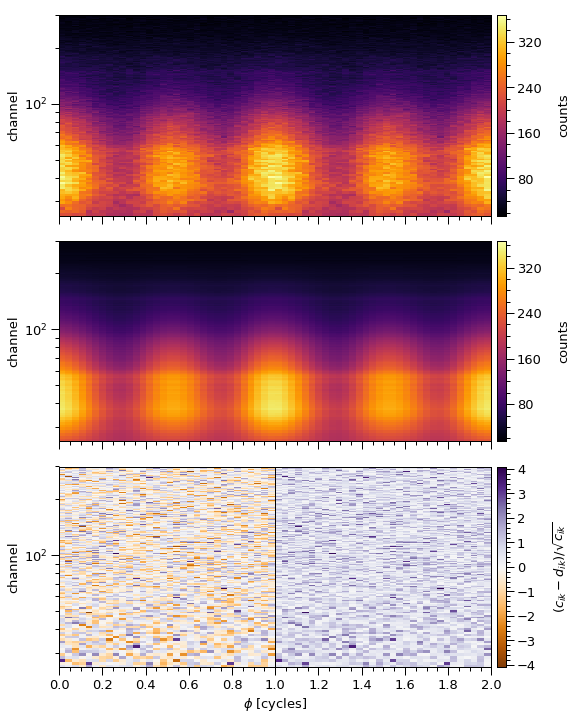

In [22]:
pp.plot(IDs=OrderedDict([('ST-U', ['run 1',]),
                         ('ST+PST', ['ST+PST',]),
                        ]),
        combine=False, # use these controls if more than one run for a posterior
        combine_all=False,
        force_combine=False,
        only_combined=False,
        nsamples=200,
        plots = {'ST-U': xpsi.ResidualPlot(),
                 'ST+PST': xpsi.ResidualPlot()})

pp.plots['ST+PST'].fig
pp.plots['ST-U'].fig

### Pulse-profile plots

There are other native plot types at our disposal. Let's check out the [PulsePlot](postprocessing.rst#xpsi.PostProcessing.PulsePlot) class:

In [23]:
xpsi.PulsePlot.declare_settings(extension='.png')

Declaring plot class settings...
Settings declared.


This time we'll just handle one of the posterior objects:

Instantiating a pulse-profile plotter for posterior checking...
Pulse-profile plotter instantiated.
Plotting signals for posterior checking...
Curating set of runs for posterior plotting...
Run set curated.
Handling posterior ST+PST...
Checking whether an existing cache can be read:
Creating new cache file...
Attempting to archive existing cache file in a subdirectory...
Targeting subdirectory: ./archive.
Exisiting cache file archived in subdirectory ./archive.
Initialising cache file...
Cache file initialised.
Cache file created.
Cache state determined.


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnU2lnbmFsIGNhY2hpbmcgbG9vcCcsIG1heD0yMDAuMCwgc3R5bGU9UHJvZ3Jlc3NTdHlsZShkZXPigKY=



PulsePlot object iterating over samples...
PulsePlot object finished iterating.
PulsePlot object finalizing...
PulsePlot object finalized.
Writing plot to disk...
PulsePlot instance plot will be written to path ./ST+PST.ST+PST__signalplot_pulse.png...
Written.
Handled posterior ST+PST.
Plotted signals for posterior checking.


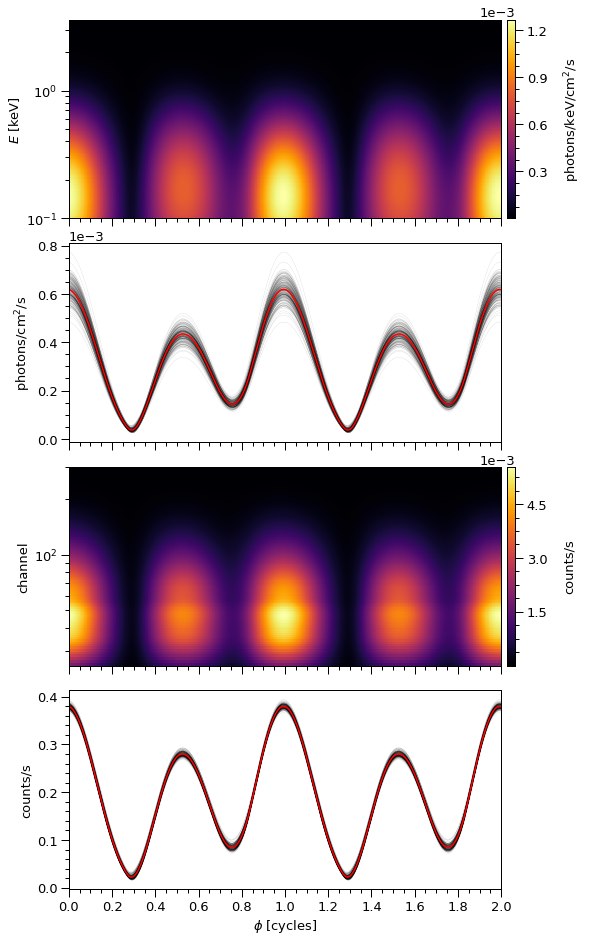

In [24]:
pp.plot(IDs=OrderedDict([ ('ST+PST', ['ST+PST',]),
                        ]),
        nsamples=200,
        plots = {'ST+PST': xpsi.PulsePlot(expectation_line_kwargs=dict(color='red'))})

pp.plots['ST+PST'].fig

We can also display the component signals. We also can change the colormap for one of the 2D signal panels:

Instantiating a pulse-profile plotter for posterior checking...
Pulse-profile plotter instantiated.
Plotting signals for posterior checking...
Curating set of runs for posterior plotting...
Run set curated.
Handling posterior ST+PST...
Checking whether an existing cache can be read:
Cache state determined.
PulsePlot object iterating over samples...
PulsePlot object finished iterating.
PulsePlot object finalizing...
PulsePlot object finalized.
Writing plot to disk...
PulsePlot instance plot will be written to path ./ST+PST.ST+PST__signalplot_pulse.png...
Written.
Handled posterior ST+PST.
Plotted signals for posterior checking.


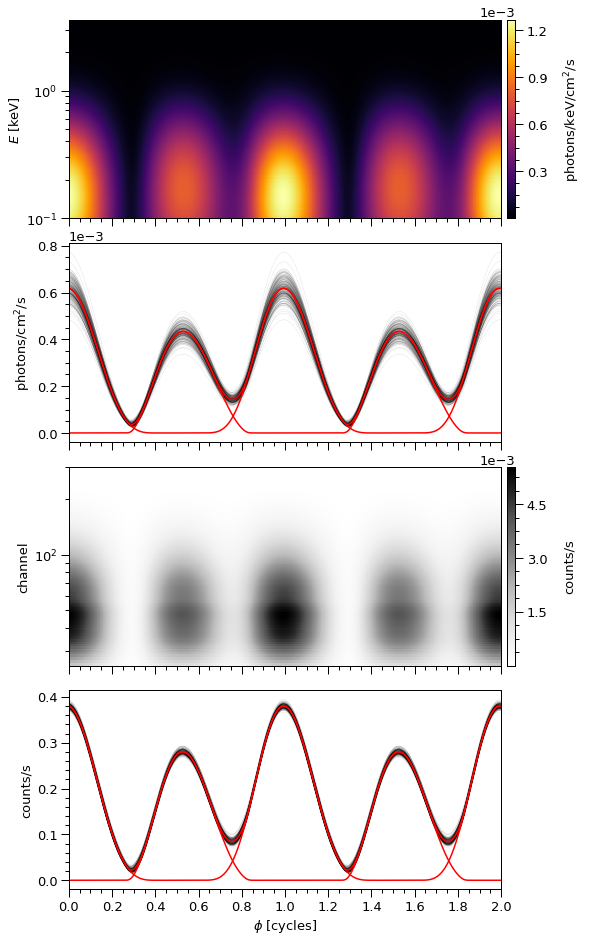

In [25]:
pp.plot(IDs=OrderedDict([ ('ST+PST', ['ST+PST',]),
                        ]),
        nsamples=200,
        plots = {'ST+PST': xpsi.PulsePlot(registered_cmap='Greys',
                                          expectation_line_kwargs=dict(color='red'),
                                          show_components=True)})

pp.plots['ST+PST'].fig

We are free to change the line style of the components, or any of the 1D signals for that matter, e.g.:

Instantiating a pulse-profile plotter for posterior checking...
Pulse-profile plotter instantiated.
Plotting signals for posterior checking...
Curating set of runs for posterior plotting...
Run set curated.
Handling posterior ST+PST...
Checking whether an existing cache can be read:
Cache state determined.
PulsePlot object iterating over samples...
PulsePlot object finished iterating.
PulsePlot object finalizing...
PulsePlot object finalized.
Writing plot to disk...
PulsePlot instance plot will be written to path ./ST+PST.ST+PST__signalplot_pulse.png...
Written.
Handled posterior ST+PST.
Plotted signals for posterior checking.


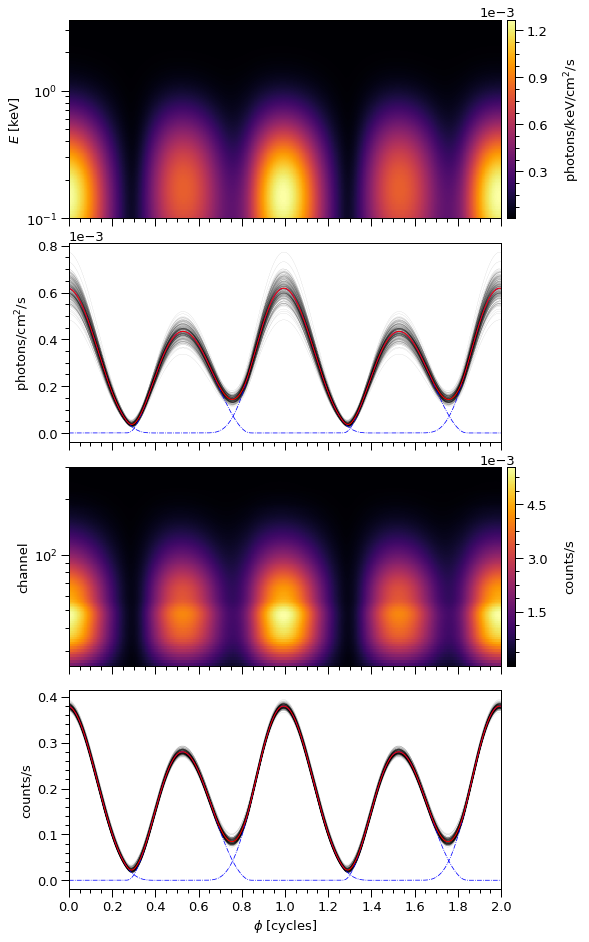

In [26]:
pp.plot(IDs=OrderedDict([ ('ST+PST', ['ST+PST',]),
                        ]),
        nsamples=200,
        plots = {'ST+PST': xpsi.PulsePlot(comp_expectation_line_kwargs=dict(color='b',
                                                                            ls='-.',
                                                                            lw=0.75,
                                                                            alpha=1.0),
                                          show_components=True)})

pp.plots['ST+PST'].fig

Let's invoke the package `fgivenx` to generate conditional posterior distributions of the 1D total incident and registered signals:

Instantiating a pulse-profile plotter for posterior checking...
Pulse-profile plotter instantiated.
Plotting signals for posterior checking...
Curating set of runs for posterior plotting...
Run set curated.
Handling posterior ST+PST...
Checking whether an existing cache can be read:
Cache state determined.
PulsePlot object iterating over samples...
Adding credible intervals on the incident photon flux signal as function of phase...



Credible intervals added.
Added conditional posterior contours for incident signal.
Adding credible intervals on the count-rate signal as function of phase...



Credible intervals added.
Added conditional posterior contours for registered signal.
PulsePlot object finished iterating.
PulsePlot object finalizing...
PulsePlot object finalized.
Writing plot to disk...
PulsePlot instance plot will be written to path ./ST+PST.ST+PST__signalplot_pulse.png...
Written.
Handled posterior ST+PST.
Plotted signals for posterior checking.


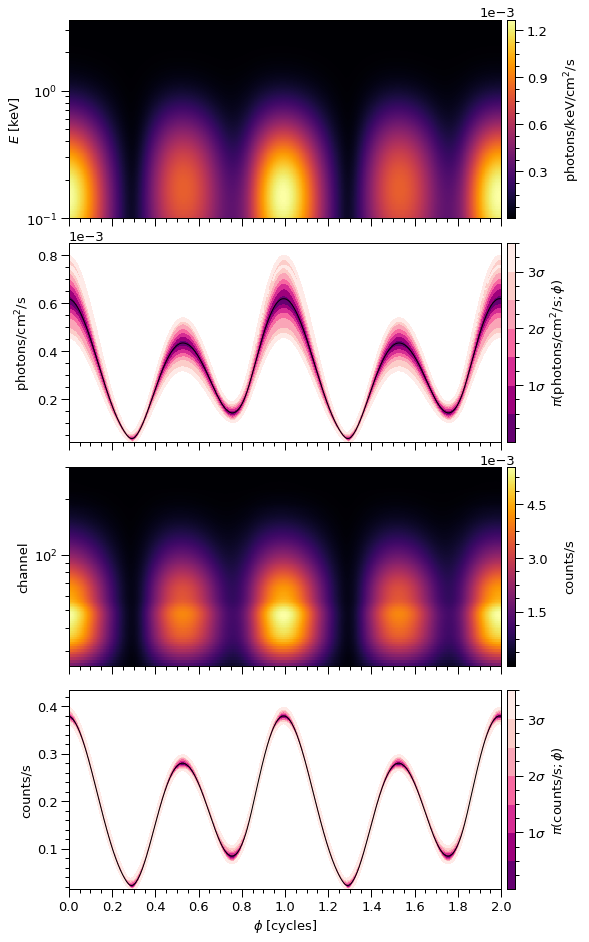

In [27]:
pp.plot(IDs=OrderedDict([ ('ST+PST', ['ST+PST',]),
                        ]),
        nsamples=200,
        plots = {'ST+PST': xpsi.PulsePlot(use_fgivenx=True)})

pp.plots['ST+PST'].fig

Let's change the colormap for the conditional posterior contours in the 1D panels:

Instantiating a pulse-profile plotter for posterior checking...
Pulse-profile plotter instantiated.
Plotting signals for posterior checking...
Curating set of runs for posterior plotting...
Run set curated.
Handling posterior ST+PST...
Checking whether an existing cache can be read:
Cache state determined.
PulsePlot object iterating over samples...
Adding credible intervals on the incident photon flux signal as function of phase...



Credible intervals added.
Added conditional posterior contours for incident signal.
Adding credible intervals on the count-rate signal as function of phase...



Credible intervals added.
Added conditional posterior contours for registered signal.
PulsePlot object finished iterating.
PulsePlot object finalizing...
PulsePlot object finalized.
Writing plot to disk...
PulsePlot instance plot will be written to path ./ST+PST.ST+PST__signalplot_pulse.png...
Written.
Handled posterior ST+PST.
Plotted signals for posterior checking.


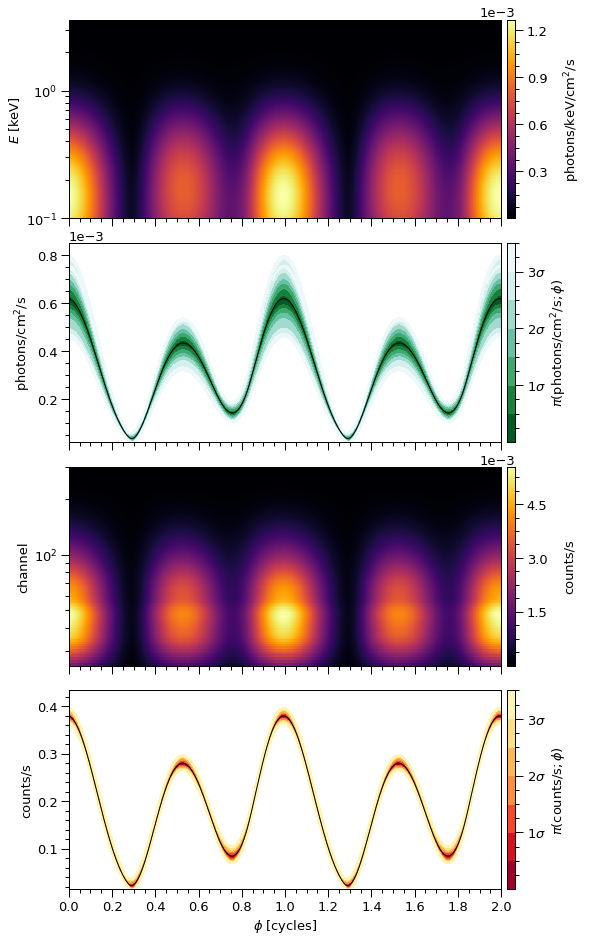

In [28]:
pp.plot(IDs=OrderedDict([ ('ST+PST', ['ST+PST',]),
                        ]),
        nsamples=200,
        plots = {'ST+PST': xpsi.PulsePlot(use_fgivenx=True,
                                          incident_contour_kwargs={'cmap':'BuGn_r'},
                                          registered_contour_kwargs={'cmap':'YlOrRd_r'})})

pp.plots['ST+PST'].fig

### Spectrum plots

Let's check out the [SpectrumPlot](postprocessing.rst#xpsi.PostProcessing.SpectrumPlot) class:

In [12]:
xpsi.SpectrumPlot.declare_settings(extension='.png')

Declaring plot class settings...
Settings declared.


Let's plot the spectra:

Instantiating a spectrum plotter for posterior checking...
Spectrum plotter instantiated.
Plotting signals for posterior checking...
Curating set of runs for posterior plotting...
Run set curated.
Handling posterior ST+PST...
Checking whether an existing cache can be read:
Cache state determined.
SpectrumPlot object iterating over samples...
SpectrumPlot object finished iterating.
SpectrumPlot object finalizing...
SpectrumPlot object finalized.
Writing plot to disk...
SpectrumPlot instance plot will be written to path ./ST+PST.ST+PST__signalplot_spectrum.png...
Written.
Handled posterior ST+PST.
Plotted signals for posterior checking.


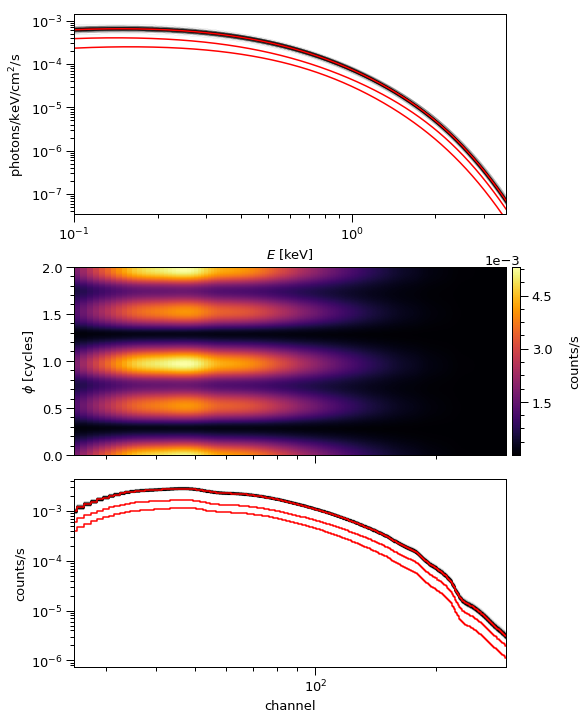

In [13]:
pp.plot(IDs=OrderedDict([ ('ST+PST', ['ST+PST',]),
                        ]),
        nsamples=200,
        plots = {'ST+PST': xpsi.SpectrumPlot(expectation_line_kwargs=dict(color='red'),
                                             show_attenuated=False,
                                             show_components=True)})

pp.plots['ST+PST'].fig

We can instead focus on the attenuated spectra incident on the telescope. Here we'll also change the sample line arguments:

Instantiating a spectrum plotter for posterior checking...
Spectrum plotter instantiated.
Plotting signals for posterior checking...
Curating set of runs for posterior plotting...
Run set curated.
Handling posterior ST+PST...
Checking whether an existing cache can be read:
Cache state determined.
SpectrumPlot object iterating over samples...
SpectrumPlot object finished iterating.
SpectrumPlot object finalizing...
SpectrumPlot object finalized.
Writing plot to disk...
SpectrumPlot instance plot will be written to path ./ST+PST.ST+PST__signalplot_spectrum.png...
Written.
Handled posterior ST+PST.
Plotted signals for posterior checking.


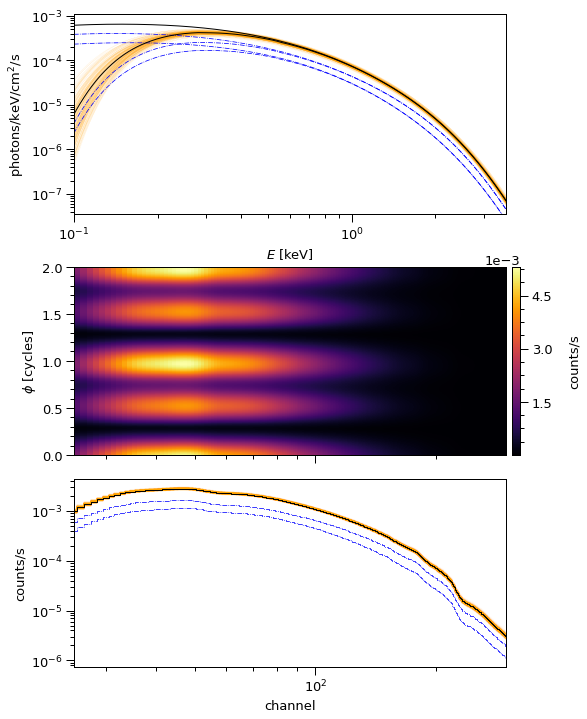

In [31]:
pp.plot(IDs=OrderedDict([ ('ST+PST', ['ST+PST',]),
                        ]),
        nsamples=200,
        plots = {'ST+PST': xpsi.SpectrumPlot(expectation_line_kwargs=dict(color='k',
                                                                          ls='-',
                                                                          lw=1.0,
                                                                          alpha=1.0),
                                             sample_line_kwargs=dict(color='orange',
                                                                     ls='-',
                                                                     lw=0.05,
                                                                     alpha=1.0),
                                             comp_expectation_line_kwargs=dict(color='b',
                                                                            ls='-.',
                                                                            lw=0.75,
                                                                            alpha=1.0),
                                             show_attenuated=True,
                                             show_components=True)})

pp.plots['ST+PST'].fig

We can manually specify the number of energies to interpolate at. The number is the fraction of the number of energies at which the signals were initially integrated and cached, and these energies span the instrument waveband. We'll reduce the number from the default to make the `fgivenx` invocation faster:

Instantiating a spectrum plotter for posterior checking...
Spectrum plotter instantiated.
Plotting signals for posterior checking...
Curating set of runs for posterior plotting...
Run set curated.
Handling posterior ST+PST...
Checking whether an existing cache can be read:
Cache state determined.
SpectrumPlot object iterating over samples...
Adding credible intervals on the incident specific photon flux spectrum...



Credible intervals added.
Adding credible intervals on the count-rate spectrum...



Credible intervals added.
Added conditional posterior contours for incident spectrum.
SpectrumPlot object finished iterating.
SpectrumPlot object finalizing...
SpectrumPlot object finalized.
Writing plot to disk...
SpectrumPlot instance plot will be written to path ./ST+PST.ST+PST__signalplot_spectrum.png...
Written.
Handled posterior ST+PST.
Plotted signals for posterior checking.


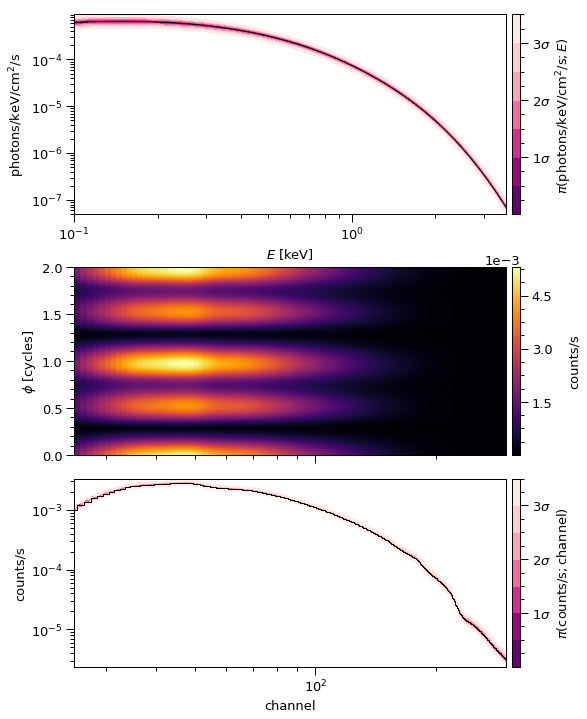

In [14]:
pp.plot(IDs=OrderedDict([ ('ST+PST', ['ST+PST',]),
                        ]),
        nsamples=200,
        plots = {'ST+PST': xpsi.SpectrumPlot(rel_num_energies=2.0,
                                             show_attenuated=False,
                                             use_fgivenx=True)})

pp.plots['ST+PST'].fig

Instantiating a spectrum plotter for posterior checking...
Spectrum plotter instantiated.
Plotting signals for posterior checking...
Curating set of runs for posterior plotting...
Run set curated.
Handling posterior ST+PST...
Checking whether an existing cache can be read:
Cache state determined.
SpectrumPlot object iterating over samples...
Adding credible intervals on the incident specific photon flux spectrum...



Credible intervals added.
Adding credible intervals on the count-rate spectrum...



Credible intervals added.
Added conditional posterior contours for incident spectrum.
SpectrumPlot object finished iterating.
SpectrumPlot object finalizing...
SpectrumPlot object finalized.
Writing plot to disk...
SpectrumPlot instance plot will be written to path ./ST+PST.ST+PST__signalplot_spectrum.png...
Written.
Handled posterior ST+PST.
Plotted signals for posterior checking.


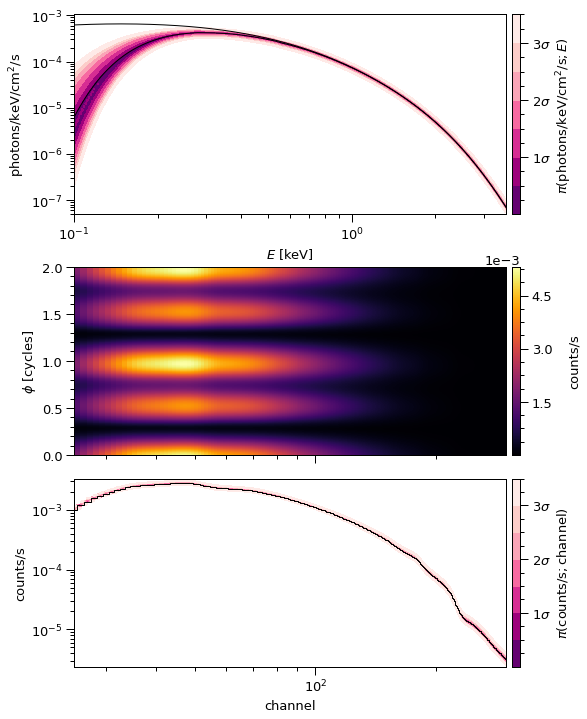

In [15]:
pp.plot(IDs=OrderedDict([ ('ST+PST', ['ST+PST',]),
                        ]),
        nsamples=200,
        plots = {'ST+PST': xpsi.SpectrumPlot(rel_num_energies=2.0,
                                             show_attenuated=True,
                                             use_fgivenx=True)})

pp.plots['ST+PST'].fig

Finally, let's include the (posterior) expected background signal registered by the instrument:

Instantiating a spectrum plotter for posterior checking...
Spectrum plotter instantiated.
Plotting signals for posterior checking...
Curating set of runs for posterior plotting...
Run set curated.
Handling posterior ST+PST...
Checking whether an existing cache can be read:
Creating new cache file...
Attempting to archive existing cache file in a subdirectory...
Targeting subdirectory: ./archive.
Exisiting cache file archived in subdirectory ./archive.
Initialising cache file...
Cache file initialised.
Cache file created.
Cache state determined.


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnU2lnbmFsIGNhY2hpbmcgbG9vcCcsIG1heD0yMDAuMCwgc3R5bGU9UHJvZ3Jlc3NTdHlsZShkZXPigKY=



SpectrumPlot object iterating over samples...
SpectrumPlot object finished iterating.
SpectrumPlot object finalizing...
SpectrumPlot object finalized.
Writing plot to disk...
SpectrumPlot instance plot will be written to path ./ST+PST.ST+PST__signalplot_spectrum.png...
Written.
Handled posterior ST+PST.
Plotted signals for posterior checking.


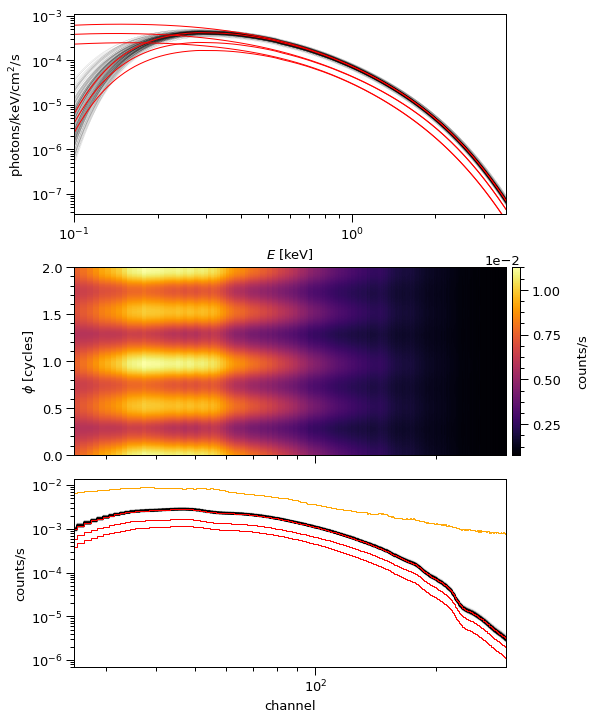

In [34]:
pp.plot(IDs=OrderedDict([ ('ST+PST', ['ST+PST',]),
                        ]),
        nsamples=200,
        plots = {'ST+PST': xpsi.SpectrumPlot(rel_num_energies=2.0,
                                             add_background=True,
                                             use_fgivenx=False,
                                             show_components=True,
                                             show_attenuated=True)})

pp.plots['ST+PST'].fig

Here the background signal has been added to the center panel (so the center panel is a transposed, phase interpolated instead of integrated version of the center panel of the [ResidualPlot](postprocessing.rst#xpsi.PostProcessing.ResidualPlot) type). The background signal has also been added to the posterior-expected signal registered from the source, yielding another step function in the bottom panel. We can, again, modify the line arguments for the signal that includes the background:

Instantiating a spectrum plotter for posterior checking...
Spectrum plotter instantiated.
Plotting signals for posterior checking...
Curating set of runs for posterior plotting...
Run set curated.
Handling posterior ST+PST...
Checking whether an existing cache can be read:
Cache state determined.
SpectrumPlot object iterating over samples...
Adding credible intervals on the incident specific photon flux spectrum...



Credible intervals added.
Adding credible intervals on the count-rate spectrum...



Credible intervals added.
Added conditional posterior contours for incident spectrum.
SpectrumPlot object finished iterating.
SpectrumPlot object finalizing...
SpectrumPlot object finalized.
Writing plot to disk...
SpectrumPlot instance plot will be written to path ./ST+PST.ST+PST__signalplot_spectrum.png...
Written.
Handled posterior ST+PST.
Plotted signals for posterior checking.


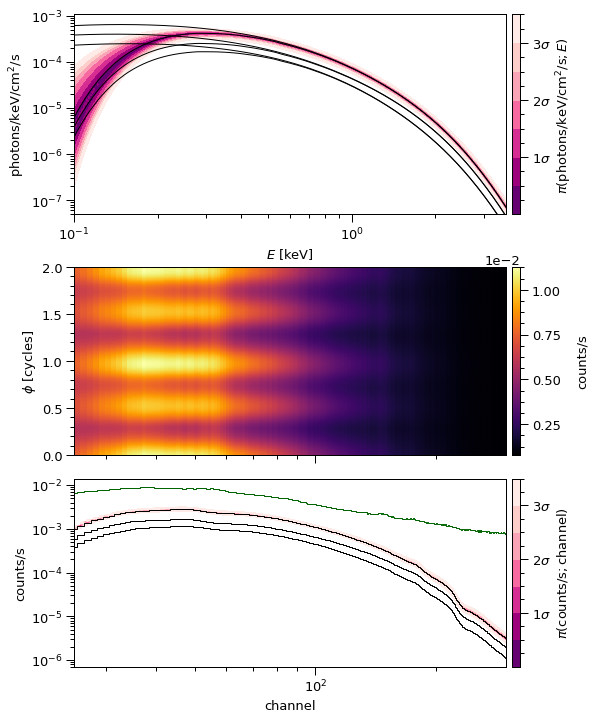

In [16]:
pp.plot(IDs=OrderedDict([ ('ST+PST', ['ST+PST',]),
                        ]),
        nsamples=200,
        plots = {'ST+PST': xpsi.SpectrumPlot(rel_num_energies=2.0,
                                             add_background=True,
                                             background_line_kwargs=dict(color='darkgreen',
                                                                         ls='-',
                                                                         lw=1.0,
                                                                         alpha=1.0),
                                             show_components=True,
                                             show_attenuated=True,
                                             use_fgivenx=True)})

pp.plots['ST+PST'].fig